In [34]:
# import libraries
import pandas as pd
from ucimlrepo import fetch_ucirepo, list_available_datasets
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Modeling utilities for the baseline pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score, confusion_matrix,
    accuracy_score, balanced_accuracy_score
)
from sklearn.feature_selection import mutual_info_classif
from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from sklearn.calibration import CalibratedClassifierCV
from imblearn.ensemble import BalancedRandomForestClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import shap
from catboost import CatBoostClassifier, Pool
from imblearn.over_sampling import SMOTE

import imblearn
import sklearn
print(f"NumPy version: {np.__version__}")
print(f"imbalanced-learn version: {imblearn.__version__}")
print(f"scikit-learn version: {sklearn.__version__}")

# Set visualization style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

NumPy version: 1.26.4
imbalanced-learn version: 0.14.0
scikit-learn version: 1.3.2


In [35]:
df = pd.read_csv("diabetic_data.csv")
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [36]:
# Mapping for categorical features from IDS_mapping
discharge_disposition_id_mapping = {
1: "Discharged to home",
2: "Discharged/transferred to another short term hospital",
3: "Discharged/transferred to SNF",
4: "Discharged/transferred to ICF",
5: "Discharged/transferred to another type of inpatient care institution",
6: "Discharged/transferred to home with home health service",
7: "Left AMA",
8: "Discharged/transferred to home under care of Home IV provider",
9: "Admitted as an inpatient to this hospital",
10: "Neonate discharged to another hospital for neonatal aftercare",
11: "Expired",
12: "Still patient or expected to return for outpatient services",
13: "Hospice / home",
14: "Hospice / medical facility",
15: "Discharged/transferred within this institution to Medicare approved swing bed",
16: "Discharged/transferred/referred another institution for outpatient services",
17: "Discharged/transferred/referred to this institution for outpatient services",
18: "NULL",
19: "Expired at home. Medicaid only, hospice.",
20: "Expired in a medical facility. Medicaid only, hospice.",
21: "Expired, place unknown. Medicaid only, hospice.",
22: "Discharged/transferred to another rehab fac including rehab units of a hospital.",
23: "Discharged/transferred to a long term care hospital.",
24: "Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare.",
25: "Not Mapped",
26: "Unknown/Invalid",
30: "Discharged/transferred to another Type of Health Care Institution not Defined Elsewhere",
27: "Discharged/transferred to a federal health care facility.",
28: "Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital.",
29: "Discharged/transferred to a Critical Access Hospital (CAH)."
}

admission_type_id_mapping = { 
1 : 'Emergency',
2 : 'Urgent',
3 : 'Elective',
4 : 'Newborn',
5 : 'Not Available',
6 : 'NULL',
7 : 'Trauma Center',
8 : 'Not Mapped' }

admission_source_id = {
1 : 'Physician Referral',
2 : 'Clinic Referral',
3 : 'HMO Referral',
4 : 'Transfer from a hospital',
5 : 'Transfer from a Skilled Nursing Facility (SNF)',
6 : 'Transfer from another health care facility',
7 : 'Emergency Room',
8 : 'Court/Law Enforcement',
9 :  'Not Available',
10 : 'Transfer from critical access hospital',
11 : 'Normal Delivery',
12 : 'Premature Delivery',
13 : 'Sick Baby',
14 : 'Extramural Birth',
15 : 'Not Available',
17 : 'NULL',
18 : 'Transfer From Another Home Health Agency',
19 : 'Readmission to Same Home Health Agency',
20 : 'Not Mapped',
21 : 'Unknown/Invalid',
22 : 'Transfer from hospital inpt/same fac reslt in a sep claim',
23 : 'Born inside this hospital',
24 : 'Born outside this hospital',
25 : 'Transfer from Ambulatory Surgery Center',
26 : 'Transfer from Hospice'}

def map_icd9_to_group(code):
    """Map ICD-9 diagnosis codes to diagnostic groups"""
    if pd.isna(code) or code == '' or str(code).lower() == 'nan':
        return 'Unknown'

    # Convert to string and handle various formats
    code_str = str(code).strip()

    # Remove any trailing decimals like .0
    if '.' in code_str:
        try:
            # Handle decimal codes
            code_num = float(code_str)
        except:
            return 'Other'
    else:
        try:
            # Handle integer codes
            code_num = float(code_str)
        except:
            return 'Other'

    # Apply ICD-9 grouping rules
    if 250.0 <= code_num < 251.0:  # Diabetes: 250.xx
        return 'Diabetes'
    elif 1 <= code_num <=129:
        return 'Infectious and parasitic diseases'
    elif 140 <= code_num <= 239:  # Neoplasms
        return 'Neoplasms'
    elif 240 <= code_num <= 279:
        return 'Endocrine, nutritional and metabolic diseases, and immunity disorders'
    elif 280 <= code_num <= 289:  
        return 'diseases of the blood and blood-forming organs'
    elif 290 <= code_num <= 319:  
        return 'mental disorders'
    elif 320 <= code_num <= 389:  
        return 'diseases of the nervous system and sense organs'
    elif (390 <= code_num <= 459) or code_num == 785:  # Circulatory
        return 'Circulatory'
    elif (460 <= code_num <= 519) or code_num == 786:  # Respiratory
        return 'Respiratory'
    elif (520 <= code_num <= 579) or code_num == 787:  # Digestive
        return 'Digestive'
    elif (580 <= code_num <= 629) or code_num == 788:  # Genitourinary
        return 'Genitourinary'
    elif 630 <= code_num <= 679: 
        return 'complications of pregnancy, childbirth, and the puerperium'
    elif 680 <= code_num <= 709:  
        return 'diseases of the skin and subcutaneous tissue'
    elif 710 <= code_num <= 739:  
        return 'Musculoskeletal'
    elif 740 <= code_num <= 759:  
        return 'congenital anomalies'
    elif 760 <= code_num <= 779:  
        return 'certain conditions originating in the perinatal period'
    elif 780 <= code_num <= 799:  
        return 'symptoms, signs, and ill-defined conditions'
    elif 800 <= code_num <= 999:  # Injury
        return 'Injury'
    else:
        return 'Other'

In [37]:
# Apply the ID mappings to make categorical features more interpretable
df['discharge_disposition_desc'] = df['discharge_disposition_id'].map(discharge_disposition_id_mapping)
df['admission_type_desc'] = df['admission_type_id'].map(admission_type_id_mapping)
df['admission_source_desc'] = df['admission_source_id'].map(admission_source_id)

# Map ICD-9 diagnosis codes to diagnostic groups
df['diag_1_group'] = df['diag_1'].apply(map_icd9_to_group)
df['diag_2_group'] = df['diag_2'].apply(map_icd9_to_group)
df['diag_3_group'] = df['diag_3'].apply(map_icd9_to_group)

# Convert readmitted to binary target
# <30 days = 1 (high risk, needs intervention)
# NO or >30 days = 0 (lower risk)
df['readmitted_binary'] = (df['readmitted'] != '<30').astype(int)

In [38]:
def create_advanced_features(df):
    """
    Create encounter-level engineered features that are safe for the baseline pipeline.

    The function focuses on transformations that do not rely on longitudinal patient 
    history, so it is compatible with random (non patient-grouped) train/validation/test 
    splits. The features emphasise medical intensity, utilisation ratios, age/medication 
    interactions, diagnosis patterns, and domain heuristics that have been shown to improve 
    recall/F1 for readmission tasks.

    Parameters
    ----------
    df : pandas.DataFrame
        Input dataframe containing raw encounter-level features.

    Returns
    -------
    pandas.DataFrame
        Dataframe augmented with additional engineered features.
    """
    from sklearn.preprocessing import KBinsDiscretizer

    df = df.copy()
    original_columns = list(df.columns)

    def safe_divide(numerator, denominator):
        denominator = denominator.replace(0, np.nan)
        result = numerator / denominator
        return result.replace([np.inf, -np.inf], np.nan).fillna(0)

    # ------------------------------------------------------------------
    # Age features
    # ------------------------------------------------------------------
    if 'age' in df.columns and 'age_numeric' not in df.columns:
        age_mapping = {
            '[0-10)': 5, '[10-20)': 15, '[20-30)': 25, '[30-40)': 35,
            '[40-50)': 45, '[50-60)': 55, '[60-70)': 65, '[70-80)': 75,
            '[80-90)': 85, '[90-100)': 95
        }
        df['age_numeric'] = df['age'].map(age_mapping).fillna(55)
        df['is_child'] = (df['age_numeric'] <= 20).astype(int)
        df['is_elderly'] = (df['age_numeric'] >= 70).astype(int)

    # ------------------------------------------------------------------
    # Healthcare utilisation intensity
    # ------------------------------------------------------------------
    encounter_cols = [
        col for col in ['number_inpatient', 'number_emergency', 'number_outpatient']
        if col in df.columns
    ]
    if encounter_cols:
        df['total_healthcare_encounters'] = df[encounter_cols].sum(axis=1)
        total_denom = df['total_healthcare_encounters'].replace(0, np.nan)
        if 'number_emergency' in df.columns:
            df['emergency_ratio'] = safe_divide(df['number_emergency'], total_denom)
        else:
            df['emergency_ratio'] = 0
        if 'number_inpatient' in df.columns:
            df['inpatient_ratio'] = safe_divide(df['number_inpatient'], total_denom)
        else:
            df['inpatient_ratio'] = 0
        if 'number_outpatient' in df.columns:
            df['outpatient_ratio'] = safe_divide(df['number_outpatient'], total_denom)
        else:
            df['outpatient_ratio'] = 0
    else:
        df['total_healthcare_encounters'] = 0
        df['emergency_ratio'] = 0
        df['inpatient_ratio'] = 0
        df['outpatient_ratio'] = 0

    # ------------------------------------------------------------------
    # Clinical intensity features
    # ------------------------------------------------------------------
    if set(['num_procedures', 'num_medications', 'number_diagnoses']).issubset(df.columns):
        df['clinical_complexity_score'] = (
            df['num_procedures'] + df['num_medications'] + df['number_diagnoses']
        )
    if 'time_in_hospital' in df.columns:
        stay_denom = df['time_in_hospital'].replace(0, np.nan)
        if 'num_medications' in df.columns:
            df['medication_intensity'] = safe_divide(df['num_medications'], stay_denom)
        if 'num_lab_procedures' in df.columns:
            df['lab_intensity'] = safe_divide(df['num_lab_procedures'], stay_denom)
        if 'num_procedures' in df.columns:
            df['procedure_intensity'] = safe_divide(df['num_procedures'], stay_denom)
    if set(['num_medications', 'number_diagnoses']).issubset(df.columns):
        df['medication_per_diagnosis'] = safe_divide(
            df['num_medications'], df['number_diagnoses'].replace(0, np.nan)
        )
    if set(['num_lab_procedures', 'number_diagnoses']).issubset(df.columns):
        df['lab_per_diagnosis'] = safe_divide(
            df['num_lab_procedures'], df['number_diagnoses'].replace(0, np.nan)
        )
    if set(['num_procedures', 'number_diagnoses']).issubset(df.columns):
        df['procedures_per_diagnosis'] = safe_divide(
            df['num_procedures'], df['number_diagnoses'].replace(0, np.nan)
        )

    # ------------------------------------------------------------------
    # Medication risk heuristics
    # ------------------------------------------------------------------
    if 'num_medications' in df.columns:
        df['polypharmacy_risk'] = np.where(
            df['num_medications'] > 5, np.exp((df['num_medications'] - 5) / 10), 0
        )
        df['log_num_medications'] = np.log1p(df['num_medications'])
        if 'time_in_hospital' in df.columns:
            df['medication_burden_score'] = df['log_num_medications'] * df['time_in_hospital']

    diabetes_med_cols = [
        'insulin', 'metformin', 'glipizide', 'glyburide', 'glimepiride',
        'glyburide-metformin', 'glipizide-metformin', 'repaglinide', 'nateglinide'
    ]
    available_meds = [col for col in diabetes_med_cols if col in df.columns]
    if available_meds:
        df['has_diabetes_meds'] = df[available_meds].apply(
            lambda row: int(any(val not in ['No', 'Steady'] for val in row)), axis=1
        )
        df['high_risk_med_combo'] = (
            (df['has_diabetes_meds'] == 1) & (df.get('num_medications', 0) > 10)
        ).astype(int)

    # Medication change heuristics that only rely on current encounter information
    diabetes_meds = [
        'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
        'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
        'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide',
        'insulin', 'glyburide-metformin', 'glipizide-metformin',
        'glimepiride-pioglitazone', 'metformin-rosiglitazone',
        'metformin-pioglitazone'
    ]
    available_meds = [col for col in diabetes_meds if col in df.columns]
    if available_meds:
        df['diabetes_med_change_count'] = df[available_meds].apply(
            lambda row: sum(val != 'No' for val in row), axis=1
        )
        df['any_diabetes_med_change'] = (df['diabetes_med_change_count'] > 0).astype(int)
        if 'insulin' in df.columns:
            df['insulin_changed'] = (df['insulin'] != 'No').astype(int)

    if {'num_lab_procedures', 'num_medications'}.issubset(df.columns):
        denom = df['num_medications'].replace(0, np.nan)
        df['lab_to_med_ratio'] = (df['num_lab_procedures'] / denom).replace(
            [np.inf, -np.inf], np.nan
        ).fillna(0)
    # ------------------------------------------------------------------
    # Admission / discharge signals
    # ------------------------------------------------------------------
    if 'admission_type_desc' in df.columns:
        df['is_emergency_admission'] = (df['admission_type_desc'] == 'Emergency').astype(int)
    elif 'admission_type_id' in df.columns:
        df['is_emergency_admission'] = (df['admission_type_id'] == 1).astype(int)
    if 'discharge_disposition_desc' in df.columns:
        high_risk_discharge = [
            'Expired', 'Hospice / home', 'Hospice / medical facility',
            'Expired at home. Medicaid only, hospice',
            'Expired in a medical facility. Medicaid only, hospice',
            'Expired, place unknown. Medicaid only, hospice'
        ]
        df['high_risk_discharge'] = df['discharge_disposition_desc'].apply(
            lambda x: int(any(risk in str(x) for risk in high_risk_discharge))
        )
    elif 'discharge_disposition_id' in df.columns:
        df['high_risk_discharge'] = df['discharge_disposition_id'].isin([11, 13, 14, 19, 20, 21]).astype(int)
    if {'age_numeric', 'number_diagnoses', 'time_in_hospital', 'admission_type_id'}.issubset(df.columns):
        df['low_risk_profile'] = (
            (df['age_numeric'] < 40) &
            (df['number_diagnoses'] <= 5) &
            (df['time_in_hospital'] <= 3) &
            (df['admission_type_id'] == 3)
        ).astype(int)

    # ------------------------------------------------------------------
    # Log transforms
    # ------------------------------------------------------------------
    if 'num_procedures' in df.columns:
        df['log_num_procedures'] = np.log1p(df['num_procedures'])
    if 'time_in_hospital' in df.columns:
        df['log_time_in_hospital'] = np.log1p(df['time_in_hospital'])
    if 'total_healthcare_encounters' in df.columns:
        df['log_total_healthcare_encounters'] = np.log1p(df['total_healthcare_encounters'])

    # ------------------------------------------------------------------
    # Diagnosis pattern signals
    # ------------------------------------------------------------------
    diag_group_cols = ['diag_1_group', 'diag_2_group', 'diag_3_group']
    if all(col in df.columns for col in diag_group_cols):
        df['diabetes_diagnosis_count'] = df[diag_group_cols].apply(
            lambda row: sum(val == 'Diabetes' for val in row), axis=1
        )
        df['circulatory_issue_flag'] = df[diag_group_cols].apply(
            lambda row: int(any(val == 'Circulatory' for val in row)), axis=1
        )
        df['diagnosis_diversity'] = df[diag_group_cols].apply(
            lambda row: len(set(row)), axis=1
        )

    diag_cols = ['diag_1', 'diag_2', 'diag_3']
    if all(col in df.columns for col in diag_cols):
        df['diag_123'] = (
            df['diag_1'].astype(str) + '_' + df['diag_2'].astype(str) + '_' + df['diag_3'].astype(str)
        )

    # ------------------------------------------------------------------
    # Laboratory flag features
    # ------------------------------------------------------------------
    if 'A1Cresult' in df.columns:
        df['a1c_abnormal_flag'] = df['A1Cresult'].isin(['>7', '>8']).astype(int)
    if 'max_glu_serum' in df.columns:
        df['glu_lab_flag'] = df['max_glu_serum'].isin(['>200', '>300']).astype(int)

    # ------------------------------------------------------------------
    # Quantile based bins (for non-linear patterns)
    # ------------------------------------------------------------------
    binning_features = [
        feature for feature in [
            'time_in_hospital', 'num_medications', 'num_lab_procedures',
            'number_diagnoses', 'num_procedures',
            'clinical_complexity_score', 'total_healthcare_encounters'
        ] if feature in df.columns
    ]
    for feature in binning_features:
        if df[feature].nunique() > 1:
            discretizer = KBinsDiscretizer(
                n_bins=min(6, df[feature].nunique()),
                encode='ordinal',
                strategy='quantile',
                subsample=None
            )
            df[f'{feature}_bin'] = discretizer.fit_transform(df[[feature]]).astype(int)

    # ------------------------------------------------------------------
    # Cross features
    # ------------------------------------------------------------------
    print("\n9️⃣  Creating diagnosis cross features...")
    if all(col in df.columns for col in diag_group_cols):
        df['diag_123_group'] = (
            df['diag_1_group'].astype(str) + '_' +
            df['diag_2_group'].astype(str) + '_' +
            df['diag_3_group'].astype(str)
        )
        created_cross = 0
        for feat in binning_features:
            bin_col = f'{feat}_bin'
            if bin_col in df.columns:
                df[f'diag_123_group_{feat}_bin'] = (
                    df['diag_123_group'].astype(str) + '_' + df[bin_col].astype(str)
                )
                created_cross += 1
        print(f"   ✓ Created diagnosis group × numeric cross features for {created_cross} new attributes")


    # ------------------------------------------------------------------
    # Negative-risk signals
    # ------------------------------------------------------------------

    # Negative-risk signals to improve true negatives
    if 'change' in df.columns:
        df['stable_medication_flag'] = (df['change'] == 'No').astype(int)
    if 'diabetesMed' in df.columns:
        df['no_diabetes_med_flag'] = (df['diabetesMed'] == 'No').astype(int)
    if 'time_in_hospital' in df.columns:
        df['short_stay_flag'] = (df['time_in_hospital'] <= 2).astype(int)
    if {'num_lab_procedures', 'time_in_hospital'}.issubset(df.columns):
        df['low_lab_utilization_flag'] = (
            (df['num_lab_procedures'] <= df['time_in_hospital'] * 2)
        ).astype(int)
    if {'number_outpatient', 'number_inpatient', 'number_emergency'}.issubset(df.columns):
        df['outpatient_dominant_flag'] = (
            df['number_outpatient'] > (df['number_inpatient'] + df['number_emergency'])
        ).astype(int)
    low_risk_discharges = {1, 6, 26, 3, 5, 8}
    if 'discharge_disposition_id' in df.columns:
        df['routine_discharge_flag'] = df['discharge_disposition_id'].isin(low_risk_discharges).astype(int)
    low_risk_diag_groups = {
        'Symptoms, signs, and ill-defined conditions',
        'Digestive',
        'Genitourinary',
        'Endocrine, nutritional and metabolic diseases, and immunity disorders',
        'Other'
    }
    for diag_col in ['diag_1_group', 'diag_2_group', 'diag_3_group']:
        if diag_col in df.columns:
            df[f'{diag_col}_low_risk_flag'] = df[diag_col].isin(low_risk_diag_groups).astype(int)
    signal_cols = [col for col in [
        'stable_medication_flag',
        'no_diabetes_med_flag',
        'short_stay_flag',
        'low_lab_utilization_flag',
        'outpatient_dominant_flag',
        'routine_discharge_flag',
        'diag_1_group_low_risk_flag',
        'diag_2_group_low_risk_flag',
        'diag_3_group_low_risk_flag'
    ] if col in df.columns]
    if signal_cols:
        df['aggregated_negative_risk_score'] = df[signal_cols].sum(axis=1)
        df['strong_negative_signature'] = (df['aggregated_negative_risk_score'] >= 4).astype(int)

    new_features = [col for col in df.columns if col not in original_columns]
    print("=" * 80)
    print("CREATING ADVANCED FEATURES FOR BASELINE PIPELINE")
    print("=" * 80)
    print(f"✅ Added {len(new_features)} engineered features")
    print("Highlights:")
    print("  • Healthcare utilisation ratios (emergency, inpatient, outpatient)")
    print("  • Clinical intensity metrics (medication/lab/procedure intensity)")
    print("  • Medication risk indicators (polypharmacy, high-risk combinations)")
    print("  • Age interactions and admission/discharge risk flags")
    print("  • Diagnosis diversity and laboratory abnormality signals")
    print("  • Quantile-binned versions of key continuous features")
    return df

In [39]:
def create_advanced_encodings(df, target_col='readmitted_binary', train_indices=None):
    """
    Create advanced encodings for categorical variables:
    - Frequency encoding
    - Target encoding (with smoothing to prevent overfitting)
    - Count encoding
    - Binary encoding for high cardinality
    
    Parameters:
    - df: DataFrame
    - target_col: name of target column for target encoding
    - train_indices: indices of training set (to prevent leakage in target encoding)
    
    Returns: DataFrame with encoded features
    """
    df = df.copy()
    
    print("="*80)
    print("CREATING ADVANCED ENCODINGS")
    print("="*80)
    
    # If no train_indices provided, use all data (but warn about potential leakage)
    if train_indices is None:
        print("⚠️  WARNING: No train_indices provided. Using full dataset for encoding.")
        print("   This is OK for exploration, but use proper train/test split for modeling!")
        train_indices = df.index
    
    # ===================================================================
    # 1. FREQUENCY ENCODING
    # ===================================================================
    print("\n1️⃣  Creating frequency encodings...")
    
    # High cardinality categorical features that benefit from frequency encoding
    freq_encode_cols = []
    
    # Identify categorical columns with many unique values
    for col in df.select_dtypes(include=['object']).columns:
        nunique = df[col].nunique()
        if 10 < nunique < 1000 and col != target_col:  # Skip if too few or too many
            freq_encode_cols.append(col)
    
    freq_encoded = 0
    for col in freq_encode_cols[:5]:  # Limit to top 5 to avoid too many features
        freq_map = df.loc[train_indices, col].value_counts(normalize=True).to_dict()
        df[f'{col}_frequency'] = df[col].map(freq_map).fillna(0)
        freq_encoded += 1
    
    print(f"   ✓ Created {freq_encoded} frequency-encoded features")
    
    # ===================================================================
    # 2. COUNT ENCODING
    # ===================================================================
    print("\n3️⃣  Creating count encodings...")
    
    count_encoded = 0
    for col in ['diag_1', 'diag_2', 'diag_3'][:3]:  # High cardinality diagnosis codes
        if col in df.columns:
            count_map = df.loc[train_indices, col].value_counts().to_dict()
            df[f'{col}_count'] = df[col].map(count_map).fillna(0)
            count_encoded += 1
    
    print(f"   ✓ Created {count_encoded} count-encoded features")
    
    # ===================================================================
    # 4. BINARY ENCODING for specific binary features
    # ===================================================================
    print("\n4️⃣  Creating binary encodings...")
    
    binary_cols = {
        'gender': {'Male': 1, 'Female': 0},
        'change': {'Ch': 1, 'No': 0},
        'diabetesMed': {'Yes': 1, 'No': 0}
    }
    
    binary_encoded = 0
    for col, mapping in binary_cols.items():
        if col in df.columns:
            df[f'{col}_binary'] = df[col].map(mapping).fillna(0)
            binary_encoded += 1
    
    print(f"   ✓ Created {binary_encoded} binary-encoded features")
    
    # ===================================================================
    # 5. ORDINAL ENCODING for naturally ordered categories
    # ===================================================================
    print("\n5️⃣  Creating ordinal encodings...")
    
    # Age is already ordinal, just encode it
    if 'age' in df.columns and 'age_numeric' not in df.columns:
        age_order = ['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)',
                     '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)']
        df['age_ordinal'] = df['age'].map({age: i for i, age in enumerate(age_order)})
    
    # Encode medication change levels if they exist
    med_change_order = {'No': 0, 'Steady': 1, 'Up': 2, 'Down': 3}
    ordinal_encoded = 0
    
    for col in df.columns:
        if 'metformin' in col.lower() or 'insulin' in col.lower():
            if df[col].dtype == 'object' and set(df[col].unique()).issubset(set(med_change_order.keys()) | {np.nan}):
                df[f'{col}_ordinal'] = df[col].map(med_change_order).fillna(0)
                ordinal_encoded += 1
    
    print(f"   ✓ Created {ordinal_encoded} ordinal-encoded features")
    
    print("\n" + "="*80)
    print("SUMMARY: Advanced Encoding Complete")
    print("="*80)
    print(f"✅ Created encodings:")
    print(f"  - Frequency encoding: {freq_encoded}")
    print(f"  - Count encoding: {count_encoded}")
    print(f"  - Binary encoding: {binary_encoded}")
    print(f"  - Ordinal encoding: {ordinal_encoded}")
    print(f"  TOTAL: ~{freq_encoded + count_encoded + binary_encoded + ordinal_encoded} new encoded features")
    print(f"\n⚠️  NOTE: Target encoding is handled in the sklearn Pipeline to prevent data leakage!")
    
    return df

In [40]:
def create_baseline_feature_set(
    df: pd.DataFrame,
    target_col: str = 'readmitted_binary',
    high_missing_threshold: float = 0.6,
    low_variance_threshold: float = 0.99
) -> pd.DataFrame:
    """
    Prepare encounter-level features for the baseline pipeline.

    Steps
    -----
    1. Remove identifier-like columns or those with excessive missingness.
    2. Drop features that are (near) constant across encounters.
    3. Augment the dataset with the advanced encounter-level features.
    4. Add additional medication interaction heuristics that do not rely on patient history.
    5. Create additional "negative-risk" signals aimed at improving true negatives.

    Parameters
    ----------
    df : pandas.DataFrame
        Raw dataframe.
    target_col : str
        Name of the target column (kept in the output).
    high_missing_threshold : float
        Columns with a missing ratio above this threshold are removed.
    low_variance_threshold : float
        Categorical columns where the dominant value exceeds this proportion are removed.

    Returns
    -------
    pandas.DataFrame
        Cleaned and feature-engineered dataframe ready for encoding.
    """
    df = df.copy()

    explicit_drop_cols = [
        'encounter_id', 'patient_nbr', 'weight', 'payer_code', 'medical_specialty',
        'readmitted'
    ]
    explicit_drop_cols = [col for col in explicit_drop_cols if col in df.columns]
    df.drop(columns=explicit_drop_cols, inplace=True, errors='ignore')

    # Automatically drop columns with excessive missingness (excluding the target)
    missing_ratio = df.isna().mean()
    high_missing_cols = [
        col for col, ratio in missing_ratio.items()
        if ratio > high_missing_threshold and col != target_col
    ]
    df.drop(columns=high_missing_cols, inplace=True, errors='ignore')

    # Drop near-constant columns
    low_variance_cols = []
    for col in df.columns:
        if col == target_col:
            continue
        series = df[col]
        nunique = series.nunique(dropna=False)
        if nunique <= 1:
            low_variance_cols.append(col)
            continue
        top_freq = series.value_counts(dropna=False, normalize=True).iloc[0]
        if top_freq >= low_variance_threshold:
            low_variance_cols.append(col)
    df.drop(columns=low_variance_cols, inplace=True, errors='ignore')

    # Add advanced encounter-level features (safe for random splits)
    df = create_advanced_features(df)

    print("Baseline feature preparation summary:")
    print(f"  • Explicitly dropped columns: {explicit_drop_cols}")
    print(f"  • High-missing columns dropped (> {high_missing_threshold:.0%} NA): {high_missing_cols}")
    print(f"  • Near-constant columns dropped (> {low_variance_threshold:.0%} same value): {low_variance_cols}")
    print(f"  • Final feature count (including target if present): {df.shape[1]}")

    return df

In [41]:
# Prepare the cleaned + engineered dataset for the baseline pipeline
baseline_df = create_baseline_feature_set(df)

target_col = 'readmitted_binary'
if target_col not in baseline_df.columns:
    raise ValueError("Target column 'readmitted_binary' is missing after feature creation.")

X_full = baseline_df.drop(columns=[target_col])
y_full = baseline_df[target_col]

# Stratified random split (no patient-level grouping)
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.20, stratify=y_full, random_state=42
 )

print("Baseline split shapes:")
print(f"  • Train: {X_train.shape}")
print(f"  • Test: {X_test.shape}")


9️⃣  Creating diagnosis cross features...
   ✓ Created diagnosis group × numeric cross features for 7 new attributes
CREATING ADVANCED FEATURES FOR BASELINE PIPELINE
✅ Added 59 engineered features
Highlights:
  • Healthcare utilisation ratios (emergency, inpatient, outpatient)
  • Clinical intensity metrics (medication/lab/procedure intensity)
  • Medication risk indicators (polypharmacy, high-risk combinations)
  • Age interactions and admission/discharge risk flags
  • Diagnosis diversity and laboratory abnormality signals
  • Quantile-binned versions of key continuous features
Baseline feature preparation summary:
  • Explicitly dropped columns: ['encounter_id', 'patient_nbr', 'weight', 'payer_code', 'medical_specialty', 'readmitted']
  • High-missing columns dropped (> 60% NA): ['max_glu_serum', 'A1Cresult']
  • Near-constant columns dropped (> 99% same value): ['nateglinide', 'chlorpropamide', 'acetohexamide', 'tolbutamide', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', '

In [42]:
from sklearn.base import BaseEstimator, TransformerMixin

class TargetEncoder(BaseEstimator, TransformerMixin):
    """Simple target mean encoder for categorical features."""
    def __init__(self, smoothing=1.0):
        self.smoothing = smoothing
        self.global_mean_ = None
        self.encoding_dict_ = {}
        self.feature_names_in_ = None

    def fit(self, X, y):
        X = pd.DataFrame(X, columns=X.columns if hasattr(X, 'columns') else self.feature_names_in_)
        self.feature_names_in_ = X.columns.tolist()
        y_series = pd.Series(y)
        self.global_mean_ = y_series.mean()
        self.encoding_dict_ = {}
        for col in self.feature_names_in_:
            stats = y_series.groupby(X[col]).agg(['mean', 'count'])
            if self.smoothing > 0:
                smoothing = 1 / (1 + np.exp(-(stats['count'] - 1) / self.smoothing))
                encodings = self.global_mean_ * (1 - smoothing) + stats['mean'] * smoothing
            else:
                encodings = stats['mean']
            self.encoding_dict_[col] = encodings
        return self

    def transform(self, X):
        X = pd.DataFrame(X, columns=self.feature_names_in_)
        transformed = pd.DataFrame(index=X.index)
        for col in self.feature_names_in_:
            mapping = self.encoding_dict_.get(col, pd.Series(dtype=float))
            encoded = X[col].map(mapping).fillna(self.global_mean_)
            transformed[f'{col}_target'] = encoded
        return transformed

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            input_features = self.feature_names_in_
        return np.array([f'{feature}_target' for feature in input_features])

In [43]:
# Encode categorical variables with target encoding and scale numeric features
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_cols = [col for col in X_train.columns if col not in categorical_cols]

numeric_skewness = X_train[numeric_cols].skew()
numeric_skewness_abs = numeric_skewness.abs()
binary_like_numeric_cols = [col for col in numeric_cols if X_train[col].nunique() <= 2]
skew_threshold = 1.0
skewed_numeric_cols = [
    col for col in numeric_cols
    if col not in binary_like_numeric_cols and numeric_skewness_abs.get(col, 0.0) > skew_threshold
 ]
non_skewed_numeric_cols = [col for col in numeric_cols if col not in skewed_numeric_cols]

print("Numeric feature groups for preprocessing:")
print(f"  • Total numeric columns: {len(numeric_cols)}")
print(f"  • Skew-corrected columns (> {skew_threshold} skew & non-binary): {len(skewed_numeric_cols)}")
print(f"  • Remaining numeric columns: {len(non_skewed_numeric_cols)}")

skewed_numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('yeojohnson', PowerTransformer(method='yeo-johnson', standardize=False)),
    ('scaler', StandardScaler())
]) if skewed_numeric_cols else None

regular_numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('target_encoder', TargetEncoder(smoothing=5.0))
])

transformers = []
if skewed_numeric_cols:
    transformers.append(('num_skewed', skewed_numeric_pipeline, skewed_numeric_cols))
if non_skewed_numeric_cols:
    transformers.append(('num_other', regular_numeric_pipeline, non_skewed_numeric_cols))
transformers.append(('cat', categorical_transformer, categorical_cols))

preprocessor = ColumnTransformer(
    transformers=transformers
 )

preprocessor.fit(X_train, y_train)

def transform_with_feature_names(transformer: ColumnTransformer, X: pd.DataFrame) -> pd.DataFrame:
    transformed = transformer.transform(X)
    feature_names = transformer.get_feature_names_out()
    return pd.DataFrame(transformed, columns=feature_names, index=X.index)

X_train_prepared = transform_with_feature_names(preprocessor, X_train)
X_test_prepared = transform_with_feature_names(preprocessor, X_test)

print("Encoded feature counts:")
print(f"  • Train: {X_train_prepared.shape}")
print(f"  • Test: {X_test_prepared.shape}")

Numeric feature groups for preprocessing:
  • Total numeric columns: 61
  • Skew-corrected columns (> 1.0 skew & non-binary): 24
  • Remaining numeric columns: 37
Encoded feature counts:
  • Train: (81412, 92)
  • Test: (20354, 92)


In [44]:
# Quick skewness snapshot for numeric features to identify heavy-tailed distributions
numeric_skewness = X_train[numeric_cols].skew().sort_values(ascending=False)
skewness_summary = (
    pd.DataFrame({'skew': numeric_skewness})
    .assign(abs_skew=lambda df_: df_['skew'].abs())
    .sort_values('abs_skew', ascending=False)
 )
display(skewness_summary.head(15))

,skew,abs_skew
polypharmacy_risk,36.891409,36.891409
number_emergency,21.659291,21.659291
low_risk_profile,17.182162,17.182162
is_child,10.861928,10.861928
number_outpatient,9.114095,9.114095
high_risk_discharge,6.295020,6.295020
lab_to_med_ratio,5.930136,5.930136
total_healthcare_encounters,5.255554,5.255554
procedure_intensity,3.795183,3.795183
number_inpatient,3.634671,3.634671


In [45]:
# Feature selection pipeline: correlation removal ➜ MI / PCA / RF voting
correlation_threshold = 0.9

print("Initial feature counts (train/test):", X_train_prepared.shape, X_test_prepared.shape)

# 1. Remove highly correlated features
# corr_matrix = X_train_prepared.corr().abs()
# upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# correlated_to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > correlation_threshold)]
correlated_to_drop = []
X_train_uncorr = X_train_prepared.drop(columns=correlated_to_drop)
X_test_uncorr = X_test_prepared.drop(columns=correlated_to_drop, errors='ignore')

print(f"Removed {len(correlated_to_drop)} highly correlated features (> {correlation_threshold})")

# 2. Mutual information analysis
mi_scores = mutual_info_classif(X_train_uncorr, y_train, random_state=42)
mutual_info_series = pd.Series(mi_scores, index=X_train_uncorr.columns).sort_values(ascending=False)
print("Top 10 features by mutual information:")
display(mutual_info_series.head(10).to_frame('mutual_information'))

# 3. PCA on numeric subset to identify variance-driving original columns
numeric_uncorr_cols = X_train_uncorr.select_dtypes(include=[np.number]).columns.tolist()
pca_feature_scores = pd.Series(dtype=float)
pca_selected_features: list[str] = []
variance_threshold = 0.95
random_state = 42

if numeric_uncorr_cols:
    scaler_for_pca = StandardScaler(with_mean=False)
    X_train_numeric = X_train_uncorr[numeric_uncorr_cols]
    X_train_numeric_scaled = scaler_for_pca.fit_transform(X_train_numeric)

    pca_full = PCA(random_state=random_state)
    pca_full.fit(X_train_numeric_scaled)

    cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
    n_components = np.searchsorted(cumulative_variance, variance_threshold) + 1
    n_components = min(n_components, X_train_numeric.shape[1])

    pca = PCA(n_components=n_components, random_state=random_state)
    pca.fit(X_train_numeric_scaled)

    loadings = np.abs(pca.components_)
    variance_weights = pca.explained_variance_ratio_.reshape(-1, 1)
    feature_contrib = (loadings * variance_weights).sum(axis=0)
    feature_contrib = feature_contrib / feature_contrib.sum()

    pca_feature_scores = pd.Series(feature_contrib, index=numeric_uncorr_cols).sort_values(ascending=False)
    cumulative_feature_contrib = pca_feature_scores.cumsum()
    pca_selected_features = cumulative_feature_contrib.index[cumulative_feature_contrib <= variance_threshold].tolist()

    if not pca_selected_features:
        pca_selected_features = [pca_feature_scores.index[0]]

    print(
        f"PCA retained {n_components} components covering {cumulative_variance[n_components-1]:.2%} variance "
        f"and {len(pca_selected_features)} original numeric features (>= {variance_threshold:.0%} contribution)."
    )
else:
    print("No numeric features detected for PCA variance analysis.")

print("Top 10 numeric features by PCA variance contribution:")
display(pca_feature_scores.head(10).to_frame('pca_weighted_contribution'))

# 4. Random Forest feature importances on the decorrelated feature set
rf_selector = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced_subsample'
 )
rf_selector.fit(X_train_uncorr, y_train)
rf_feature_importance = pd.Series(
    rf_selector.feature_importances_, index=X_train_uncorr.columns
).sort_values(ascending=False)
print("Top 10 features by Random Forest importance:")
display(rf_feature_importance.head(10).to_frame('rf_importance'))

# 5. Voting mechanism across MI, PCA, and RF
top_k = max(50, int(0.15 * len(X_train_uncorr.columns)))
mi_top = set(mutual_info_series.head(top_k).index)
rf_top = set(rf_feature_importance.head(top_k).index)
pca_top = set(pca_feature_scores.head(top_k).index if not pca_feature_scores.empty else [])

all_features = set(X_train_uncorr.columns)
votes = {feature: 0 for feature in all_features}
for feature in mi_top:
    votes[feature] += 1
for feature in rf_top:
    votes[feature] += 1
for feature in pca_top:
    votes[feature] += 1

selected_features = [feature for feature, vote in votes.items() if vote >= 2]
if not selected_features:
    print("Vote threshold too strict; falling back to mutual information top features.")
    selected_features = list(mutual_info_series.head(top_k).index)

X_train_final = X_train_uncorr[selected_features]
X_test_final = X_test_uncorr[selected_features]

print("Feature selection summary:")
print(f"  • Correlated features removed: {len(correlated_to_drop)}")
print(f"  • Features considered after decorrelation: {X_train_uncorr.shape[1]}")
print(f"  • Selected features after voting (>=2 votes): {len(selected_features)}")
print(f"  • Final feature shapes (train/test): {X_train_final.shape}, {X_test_final.shape}")

Initial feature counts (train/test): (81412, 92) (20354, 92)
Removed 0 highly correlated features (> 0.9)
Top 10 features by mutual information:


,mutual_information
num_skewed__number_inpatient,0.016801
cat__repaglinide_target,0.016138
cat__glyburide_target,0.014808
cat__discharge_disposition_desc_target,0.014538
num_skewed__inpatient_ratio,0.014253
cat__metformin_target,0.012912
num_other__total_healthcare_encounters_bin,0.012198
cat__glimepiride_target,0.011629
num_skewed__total_healthcare_encounters,0.011311
cat__pioglitazone_target,0.011298


PCA retained 50 components covering 95.52% variance and 84 original numeric features (>= 95% contribution).
Top 10 numeric features by PCA variance contribution:


,pca_weighted_contribution
num_other__no_diabetes_med_flag,0.013828
cat__diabetesMed_target,0.013828
num_other__any_diabetes_med_change,0.013749
num_other__insulin_changed,0.013594
num_other__stable_medication_flag,0.013547
cat__change_target,0.013547
num_other__aggregated_negative_risk_score,0.013384
num_other__number_diagnoses,0.013319
num_other__number_diagnoses_bin,0.013221
num_skewed__medication_per_diagnosis,0.013182


Top 10 features by Random Forest importance:


,rf_importance
num_skewed__lab_to_med_ratio,0.028747
cat__diag_1_target,0.028249
num_skewed__lab_intensity,0.028174
cat__diag_3_target,0.027779
num_skewed__lab_per_diagnosis,0.027659
cat__diag_123_group_num_lab_procedures_bin_target,0.027547
cat__diag_2_target,0.027540
cat__diag_123_group_num_procedures_bin_target,0.027298
cat__diag_123_group_number_diagnoses_bin_target,0.027228
cat__diag_123_group_time_in_hospital_bin_target,0.026813


Feature selection summary:
  • Correlated features removed: 0
  • Features considered after decorrelation: 92
  • Selected features after voting (>=2 votes): 52
  • Final feature shapes (train/test): (81412, 52), (20354, 52)


In [46]:
# Build monotonic constraints for negative-risk features (higher value ⇒ lower readmission risk)
negative_risk_base_features = [
    'stable_medication_flag',
    'no_diabetes_med_flag',
    'short_stay_flag',
    'low_lab_utilization_flag',
    'outpatient_dominant_flag',
    'routine_discharge_flag',
    'diag_1_group_low_risk_flag',
    'diag_2_group_low_risk_flag',
    'diag_3_group_low_risk_flag',
    'aggregated_negative_risk_score',
    'strong_negative_signature'
 ]

def locate_negative_risk_feature(raw_name: str) -> str | None:
    prefixes = ['num_skewed__', 'num_other__', 'num__']
    for prefix in prefixes:
        candidate = f"{prefix}{raw_name}"
        if candidate in X_train_final.columns:
            return candidate
    return None

negative_risk_num_features = list(filter(None, (locate_negative_risk_feature(name) for name in negative_risk_base_features)))

monotonic_constraints = []
for feature in X_train_final.columns:
    if feature in negative_risk_num_features:
        monotonic_constraints.append(-1)  # enforce decreasing monotonic relationship
    else:
        monotonic_constraints.append(0)

negative_constraints_applied = sum(1 for value in monotonic_constraints if value != 0)
negative_risk_columns_present = [
    feature for feature in negative_risk_num_features if feature in X_train_final.columns
 ]

print("Monotonic constraint summary:")
print(f"  • Total features: {len(X_train_final.columns)}")
print(f"  • Negative-risk features constrained: {negative_constraints_applied}")
print(f"  • Sample constrained features: {negative_risk_columns_present[:5]}")

Monotonic constraint summary:
  • Total features: 52
  • Negative-risk features constrained: 7
  • Sample constrained features: ['num_other__stable_medication_flag', 'num_other__no_diabetes_med_flag', 'num_other__diag_1_group_low_risk_flag', 'num_other__diag_2_group_low_risk_flag', 'num_other__diag_3_group_low_risk_flag']


In [47]:
# PCA component interpretation: top contributing original numeric features
if pca is not None and numeric_uncorr_cols:
    component_contributions = []
    for idx, (component, variance_ratio) in enumerate(zip(pca.components_, pca.explained_variance_ratio_), start=1):
        component_series = pd.Series(component, index=numeric_uncorr_cols)
        top_features = component_series.abs().sort_values(ascending=False).head(5)
        component_contributions.append({
            'component': f'PC{idx}',
            'explained_variance_ratio': variance_ratio,
            'top_features': ', '.join(top_features.index)
        })
    pca_component_summary = pd.DataFrame(component_contributions)
    display(pca_component_summary)
else:
    print("No numeric features available for PCA component interpretation.")

,component,explained_variance_ratio,top_features
0,PC1,0.124195,"num_skewed__clinical_complexity_score, num_ske..."
1,PC2,0.066910,"num_skewed__procedures_per_diagnosis, num_skew..."
2,PC3,0.061882,"num_skewed__total_healthcare_encounters, num_s..."
3,PC4,0.057145,"num_skewed__medication_intensity, num_skewed__..."
4,PC5,0.050632,"cat__diag_123_group_target, cat__diag_123_grou..."
5,PC6,0.043393,"num_skewed__lab_intensity, num_skewed__lab_per..."
6,PC7,0.035217,"num_other__number_diagnoses, num_other__number..."
7,PC8,0.029596,"num_other__aggregated_negative_risk_score, num..."
8,PC9,0.026694,"num_other__outpatient_dominant_flag, num_skewe..."
9,PC10,0.025340,"num_other__has_diabetes_meds, cat__insulin_tar..."


In [48]:
def evaluate_models(
    models: dict,
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_test: pd.DataFrame,
    y_test: pd.Series,
    cv_splits: int = 5,
    imbalance_handling: str = 'smote',
    fit_params_map: dict | None = None,
    imbalance_threshold: float = 0.35,
    smote_kwargs: dict | None = None,
    groups: np.ndarray | None = None,
    crossval_data: dict | None = None
) -> dict:
    """
    Train and evaluate models using cross-validation on the training data (with proper
    leakage-safe folds) and report metrics on train and test splits.

    Parameters
    ----------
    models : dict
        Mapping of model names to estimators (already initialised).
    X_train, X_test : pd.DataFrame
        Preprocessed & feature-selected matrices for the training/test splits.
    y_train, y_test : pd.Series
        Target vectors for training/test splits.
    cv_splits : int
        Number of cross-validation folds.
    imbalance_handling : {'smote', 'auto', 'none'}
        Strategy for dealing with class imbalance.
    fit_params_map : dict | None
        Optional mapping of model name to kwargs passed into estimator.fit().
    imbalance_threshold : float
        Threshold on minority class ratio below which SMOTE variants are evaluated.
    smote_kwargs : dict | None
        Extra keyword arguments passed to SMOTE initialisation.
    groups : np.ndarray | None
        Optional group labels (e.g., patient identifiers) for grouped CV.
    crossval_data : dict | None
        Supplies raw training data and builder functions so that cross-validation can
        redo preprocessing/feature selection inside each fold to avoid leakage.

        Expected keys:
            - 'X_train_raw': DataFrame of raw training features (prior to preprocessing).
            - 'prepare_features': callable returning (preprocessor, feature_groups, X_train_prepared, X_valid_prepared).
            - 'prepare_kwargs': optional dict of kwargs for the callable.
            - 'feature_selector_params': parameters to instantiate FeatureSelector per fold.

    Returns
    -------
    dict
        Dictionary keyed by model name (with optional " (SMOTE)" suffix) containing
        cross-validation scores, train/test metrics, fitted estimators, and metadata.
    """
    if not isinstance(X_train, pd.DataFrame):
        X_train = pd.DataFrame(X_train)
    else:
        X_train = X_train.copy()
    if not isinstance(X_test, pd.DataFrame):
        X_test = pd.DataFrame(X_test, columns=X_train.columns)
    else:
        X_test = X_test.copy()
    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    if not isinstance(y_train, pd.Series):
        y_train = pd.Series(y_train)
    else:
        y_train = y_train.copy()
    if not isinstance(y_test, pd.Series):
        y_test = pd.Series(y_test)
    else:
        y_test = y_test.copy()
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)
    if groups is not None:
        groups = np.asarray(groups)
        if len(groups) != len(y_train):
            raise ValueError("Length of groups array must match y_train.")
    
    results: dict[str, dict] = {}
    fit_params_map = fit_params_map or {}
    imbalance_option = imbalance_handling.lower()
    if imbalance_option not in {'smote', 'auto', 'none'}:
        raise ValueError(
            f"Unsupported imbalance_handling '{imbalance_handling}'. Choose from 'smote', 'auto', or 'none'."
        )
    
    class_distribution = y_train.value_counts(normalize=True)
    if class_distribution.empty:
        raise ValueError("y_train must contain at least one class.")
    minority_ratio = class_distribution.min()
    evaluate_with_smote = (
        imbalance_option in {'smote', 'auto'} and minority_ratio < imbalance_threshold
    )
    
    smote_config = {'random_state': 42}
    if smote_kwargs:
        smote_config.update(smote_kwargs)
    
    if evaluate_with_smote:
        print(
            f"Detected class imbalance (minority ratio={minority_ratio:.3f} < threshold={imbalance_threshold:.2f}). "
            "Evaluating baseline and SMOTE variants."
        )
    else:
        if imbalance_option in {'smote', 'auto'}:
            print(
                f"Minority ratio={minority_ratio:.3f} meets threshold; proceeding without SMOTE variants."
            )
        else:
            print(
                f"Imbalance handling disabled (minority ratio={minority_ratio:.3f})."
            )
    
    scoring_metrics = [
        'precision',
        'recall',
        'f1',
        'accuracy',
        'balanced_accuracy',
        'roc_auc',
        'average_precision'
    ]
    
    # ------------------------------------------------------------------
    # Prepare cross-validation folds with leakage-safe preprocessing
    # ------------------------------------------------------------------
    fold_datasets: list[dict[str, pd.DataFrame | pd.Series]] = []
    splitter_name = 'StratifiedKFold'
    if crossval_data is not None:
        X_train_raw = crossval_data.get('X_train_raw')
        if X_train_raw is None:
            raise ValueError("crossval_data must include 'X_train_raw'.")
        if not isinstance(X_train_raw, pd.DataFrame):
            X_train_raw = pd.DataFrame(X_train_raw)
        X_train_raw = X_train_raw.reset_index(drop=True)
        prepare_features_func = crossval_data.get('prepare_features', prepare_preprocessed_features)
        prepare_kwargs = crossval_data.get('prepare_kwargs', {})
        feature_selector_params = crossval_data.get('feature_selector_params', {})
        if groups is not None:
            splitter = StratifiedGroupKFold(n_splits=cv_splits, shuffle=True, random_state=42)
            split_indices = list(splitter.split(X_train_raw, y_train, groups))
            splitter_name = 'StratifiedGroupKFold'
        else:
            splitter = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)
            split_indices = list(splitter.split(X_train_raw, y_train))
            splitter_name = 'StratifiedKFold'
            
        for train_idx, valid_idx in split_indices:
            X_fold_train_raw = X_train_raw.iloc[train_idx]
            X_fold_valid_raw = X_train_raw.iloc[valid_idx]
            y_fold_train = y_train.iloc[train_idx]
            y_fold_valid = y_train.iloc[valid_idx]
            _, _, X_fold_train_prepared, X_fold_valid_prepared = prepare_features_func(
                X_fold_train_raw,
                X_fold_valid_raw,
                y_fold_train,
                **prepare_kwargs
            )
            selector_fold = FeatureSelector(**feature_selector_params)
            selector_fold.fit(X_fold_train_prepared, y_fold_train)
            X_fold_train_final = selector_fold.transform(X_fold_train_prepared)
            X_fold_valid_final = selector_fold.transform(X_fold_valid_prepared)
            fold_datasets.append({
                'X_train': X_fold_train_final.reset_index(drop=True),
                'X_valid': X_fold_valid_final.reset_index(drop=True),
                'y_train': y_fold_train.reset_index(drop=True),
                'y_valid': y_fold_valid.reset_index(drop=True)
            })
    else:
        warnings.warn(
            "crossval_data not provided; cross-validation will operate on preprocessed features. "
            "Results may be optimistically biased if target-dependent encodings were applied beforehand.",
            RuntimeWarning
        )
        if groups is not None:
            splitter = StratifiedGroupKFold(n_splits=cv_splits, shuffle=True, random_state=42)
            split_indices = list(splitter.split(X_train, y_train, groups))
            splitter_name = 'StratifiedGroupKFold'
        else:
            splitter = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)
            split_indices = list(splitter.split(X_train, y_train))
            splitter_name = 'StratifiedKFold'
        for train_idx, valid_idx in split_indices:
            fold_datasets.append({
                'X_train': X_train.iloc[train_idx].reset_index(drop=True),
                'X_valid': X_train.iloc[valid_idx].reset_index(drop=True),
                'y_train': y_train.iloc[train_idx].reset_index(drop=True),
                'y_valid': y_train.iloc[valid_idx].reset_index(drop=True)
            })
    if fold_datasets:
        print(f"Cross-validation splitter: {splitter_name} (n_splits={cv_splits})")
    
    def compute_metrics(model, X: pd.DataFrame, y: pd.Series) -> dict:
        preds = model.predict(X)
        if hasattr(model, 'predict_proba'):
            probs = model.predict_proba(X)[:, 1]
        elif hasattr(model, 'decision_function'):
            decision = model.decision_function(X)
            probs = (decision - decision.min()) / (decision.max() - decision.min() + 1e-8)
        else:
            probs = preds.astype(float)
        cm = confusion_matrix(y, preds, labels=[0, 1])
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        try:
            roc_auc = roc_auc_score(y, probs)
        except ValueError:
            roc_auc = np.nan
        try:
            avg_precision = average_precision_score(y, probs)
        except ValueError:
            avg_precision = np.nan
        return {
            'precision': precision_score(y, preds, zero_division=0),
            'recall': recall_score(y, preds, zero_division=0),
            'f1': f1_score(y, preds, zero_division=0),
            'accuracy': accuracy_score(y, preds),
            'balanced_accuracy': balanced_accuracy_score(y, preds),
            'specificity': specificity,
            'roc_auc': roc_auc,
            'average_precision': avg_precision,
            'confusion_matrix': cm,
            'probabilities': probs
        }
    
    for model_name, estimator in models.items():
        print("-" * 80)
        print(f"Training model: {model_name}")
        fit_params = fit_params_map.get(model_name, {})
        variant_options = [('', False, 'Baseline')]
        if evaluate_with_smote:
            variant_options.append((' (SMOTE)', True, 'SMOTE'))
        for label_suffix, use_smote, variant_name in variant_options:
            variant_label = f"{model_name}{label_suffix}"
            print(f"Variant: {variant_name}")
            cv_metric_history = {metric: [] for metric in scoring_metrics}
            if fold_datasets:
                for fold in fold_datasets:
                    X_fold_train = fold['X_train']
                    y_fold_train = fold['y_train']
                    X_fold_valid = fold['X_valid']
                    y_fold_valid = fold['y_valid']
                    if use_smote:
                        smote = SMOTE(**smote_config)
                        X_fold_resampled, y_fold_resampled = smote.fit_resample(X_fold_train, y_fold_train)
                        X_fold_resampled = pd.DataFrame(X_fold_resampled, columns=X_fold_train.columns)
                        y_fold_resampled = pd.Series(y_fold_resampled)
                    else:
                        X_fold_resampled, y_fold_resampled = X_fold_train, y_fold_train
                    estimator_cv = clone(estimator)
                    fit_params_variant = fit_params.copy() if fit_params else {}
                    if fit_params_variant:
                        estimator_cv.fit(X_fold_resampled, y_fold_resampled, **fit_params_variant)
                    else:
                        estimator_cv.fit(X_fold_resampled, y_fold_resampled)
                    metrics_valid = compute_metrics(estimator_cv, X_fold_valid, y_fold_valid)
                    for metric in scoring_metrics:
                        cv_metric_history[metric].append(metrics_valid[metric])
            cv_scores = {
                f'test_{metric}': np.array(cv_metric_history[metric], dtype=float)
                for metric in scoring_metrics
            }
            if any(len(values) for values in cv_metric_history.values()):
                print("Cross-validation averages:")
                for metric in scoring_metrics:
                    values = cv_metric_history[metric]
                    if not values:
                        continue
                    print(
                        f"  {metric.replace('_', ' ').upper()}: {np.nanmean(values):.3f} ± {np.nanstd(values):.3f}"
                    )
            else:
                print("Cross-validation skipped (no folds computed).")
            
            if use_smote:
                smote = SMOTE(**smote_config)
                X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
                X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train.columns)
                y_train_resampled = pd.Series(y_train_resampled, name=y_train.name)
            else:
                X_train_resampled, y_train_resampled = X_train, y_train
            estimator_fitted = clone(estimator)
            if fit_params:
                estimator_fitted.fit(X_train_resampled, y_train_resampled, **fit_params)
            else:
                estimator_fitted.fit(X_train_resampled, y_train_resampled)
            metrics_train = compute_metrics(estimator_fitted, X_train, y_train)
            metrics_test = compute_metrics(estimator_fitted, X_test, y_test)
            results[variant_label] = {
                'cv_scores': cv_scores,
                'train': metrics_train,
                'test': metrics_test,
                'estimator': estimator_fitted,
                'base_estimator': estimator_fitted,
                'variant': variant_name,
                'is_smote': use_smote
            }
            print("Test metrics:")
            for metric, value in metrics_test.items():
                if metric in ['confusion_matrix', 'probabilities']:
                    if metric == 'confusion_matrix':
                        print(f"  {metric}:\n{value}")
                    continue
                if value is None or (isinstance(value, float) and np.isnan(value)):
                    print(f"  {metric}: nan")
                else:
                    print(f"  {metric}: {value:.3f}")
    return results

In [49]:
def summarise_results(results: dict) -> pd.DataFrame:
    rows = []
    for model_name, metrics in results.items():
        cv_scores = metrics['cv_scores']
        row = {
            'model': model_name,
            'Val Accuracy (CV)': cv_scores['test_accuracy'].mean(),
            'Val Balanced Acc (CV)': cv_scores['test_balanced_accuracy'].mean(),
            'Val Precision (CV)': cv_scores['test_precision'].mean(),
            'Val Recall (CV)': cv_scores['test_recall'].mean(),
            'Val F1 (CV)': cv_scores['test_f1'].mean(),
            'Val ROC-AUC (CV)': cv_scores['test_roc_auc'].mean(),
            'Val Avg Precision (CV)': cv_scores['test_average_precision'].mean(),
            'Test Accuracy': metrics['test']['accuracy'],
            'Test Balanced Acc': metrics['test']['balanced_accuracy'],
            'Test Specificity': metrics['test']['specificity'],
            'Test Precision': metrics['test']['precision'],
            'Test Recall': metrics['test']['recall'],
            'Test F1': metrics['test']['f1'],
            'Test ROC-AUC': metrics['test']['roc_auc'],
            'Test Avg Precision': metrics['test']['average_precision'],
            'Train Accuracy': metrics['train']['accuracy'],
            'Train Balanced Acc': metrics['train']['balanced_accuracy'],
            'Train Precision': metrics['train']['precision'],
            'Train Recall': metrics['train']['recall'],
            'Train F1': metrics['train']['f1'],
            'Train ROC-AUC': metrics['train']['roc_auc']
        }
        rows.append(row)
    summary_df = pd.DataFrame(rows)
    return summary_df.set_index('model').sort_values(by='Test F1', ascending=False)

In [50]:
# Define enhanced baseline models with imbalance-aware settings
positive_rate = y_train.mean()
pos_weight = (1 - positive_rate) / positive_rate
print(f"Positive rate in training data: {positive_rate:.3f} (scale_pos_weight={pos_weight:.2f})")

baseline_models = {
    'LogisticRegression': LogisticRegression(
        penalty='l2',
        C=1.0,
        solver='liblinear',
        class_weight='balanced',
        random_state=42,
        max_iter=200
    ),
    'Random Forest': RandomForestClassifier(
            n_estimators=200,
            max_depth=10,
            min_samples_split=100,
            min_samples_leaf=50,
            class_weight='balanced',
            random_state=42,
            n_jobs=-1
        ),
    'XGBoost': XGBClassifier(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=6,
        min_child_weight=5,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=pos_weight,
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42
    ),
    'LightGBM': LGBMClassifier(
        n_estimators=400,
        learning_rate=0.05,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=pos_weight,
        random_state=42
    ),
    'CatBoost': CatBoostClassifier(
            iterations=600,
            learning_rate=0.05,
            depth=6,
            l2_leaf_reg=3.0,
            loss_function='Logloss',
            eval_metric='AUC',
            random_seed=42,
            scale_pos_weight=pos_weight,
            border_count=128,
            verbose=0,
            allow_writing_files=False
        )
}

baseline_results = evaluate_models(
    baseline_models,
    X_train_final, y_train,
    X_test_final, y_test,
    cv_splits=5
)


Positive rate in training data: 0.888 (scale_pos_weight=0.13)
Detected class imbalance (minority ratio=0.112 < threshold=0.35). Evaluating baseline and SMOTE variants.
Cross-validation splitter: StratifiedKFold (n_splits=5)
--------------------------------------------------------------------------------
Training model: LogisticRegression
Variant: Baseline
Cross-validation averages:
  PRECISION: 0.919 ± 0.002
  RECALL: 0.650 ± 0.005
  F1: 0.762 ± 0.004
  ACCURACY: 0.639 ± 0.005
  BALANCED ACCURACY: 0.597 ± 0.005
  ROC AUC: 0.639 ± 0.009
  AVERAGE PRECISION: 0.928 ± 0.003
Test metrics:
  precision: 0.923
  recall: 0.646
  f1: 0.760
  accuracy: 0.638
  balanced_accuracy: 0.607
  specificity: 0.568
  roc_auc: 0.651
  average_precision: 0.931
  confusion_matrix:
[[ 1291   980]
 [ 6393 11690]]
Variant: SMOTE
Cross-validation averages:
  PRECISION: 0.918 ± 0.002
  RECALL: 0.653 ± 0.006
  F1: 0.763 ± 0.004
  ACCURACY: 0.640 ± 0.005
  BALANCED ACCURACY: 0.594 ± 0.007
  ROC AUC: 0.633 ± 0.009
  

In [51]:
# Summarise results in a comparison table using CV (validation proxy) and test metrics
baseline_summary = summarise_results(baseline_results)
baseline_summary

,Val Accuracy (CV),Val Balanced Acc (CV),Val Precision (CV),Val Recall (CV),Val F1 (CV),Val ROC-AUC (CV),Val Avg Precision (CV),Test Accuracy,Test Balanced Acc,Test Specificity,...,Test Recall,Test F1,Test ROC-AUC,Test Avg Precision,Train Accuracy,Train Balanced Acc,Train Precision,Train Recall,Train F1,Train ROC-AUC
model,,,,,,,,,,,,,,,,,,,,,
Random Forest (SMOTE),0.849862,0.554289,0.900063,0.934795,0.917099,0.646208,0.928476,0.847155,0.552818,0.173932,...,0.931704,0.915478,0.651508,0.930762,0.852860,0.565503,0.902501,0.935431,0.918671,0.693199
LightGBM,0.700204,0.617536,0.921825,0.723958,0.810969,0.668533,0.936145,0.691019,0.620499,0.529723,...,0.711276,0.803549,0.674696,0.938004,0.741488,0.747350,0.960042,0.739803,0.835655,0.831303
XGBoost,0.694615,0.618817,0.922555,0.716395,0.806494,0.670013,0.936781,0.686646,0.624391,0.544254,...,0.704529,0.799799,0.677922,0.939198,0.732054,0.731119,0.955720,0.732323,0.829239,0.812671
CatBoost,0.689567,0.618238,0.922696,0.710063,0.802521,0.669257,0.936084,0.681684,0.626412,0.555262,...,0.697561,0.795660,0.679445,0.938582,0.718469,0.714042,0.951559,0.719741,0.819573,0.793652
Random Forest,0.689714,0.616203,0.922041,0.710837,0.802771,0.664327,0.933663,0.678785,0.619390,0.542933,...,0.695847,0.793780,0.673339,0.936684,0.705977,0.671645,0.938632,0.715842,0.812237,0.732352
LightGBM (SMOTE),0.655198,0.619776,0.925626,0.665376,0.774182,0.669233,0.936559,0.650093,0.629232,0.602378,...,0.656086,0.769141,0.679886,0.939640,0.686570,0.717885,0.957092,0.677571,0.793433,0.798190
LogisticRegression (SMOTE),0.639746,0.593902,0.917859,0.652919,0.763032,0.633282,0.925941,0.639481,0.601890,0.553501,...,0.650279,0.762186,0.646566,0.929754,0.643198,0.596761,0.918614,0.656541,0.765776,0.637447
LogisticRegression,0.638579,0.597288,0.919078,0.650444,0.761760,0.638759,0.927619,0.637762,0.607468,0.568472,...,0.646464,0.760251,0.650697,0.930687,0.639721,0.599471,0.919750,0.651287,0.762581,0.642117
XGBoost (SMOTE),0.645728,0.620317,0.926512,0.653029,0.766080,0.667450,0.935966,0.637565,0.624684,0.608102,...,0.641265,0.758677,0.674392,0.938279,0.672690,0.708774,0.955633,0.662321,0.782390,0.784298


## SHAP Feature Importance Analysis

SHAP contribution summary for ALL features (LightGBM, test set):
Top 20 most important features:


,mean_abs_shap,mean_shap,feature_mean
cat__discharge_disposition_desc_target,0.169375,-0.005671,0.887219
num_skewed__discharge_disposition_id,0.151319,0.015123,0.013645
num_skewed__number_inpatient,0.148071,0.016018,0.008414
num_skewed__inpatient_ratio,0.146754,-0.007503,0.007344
cat__diag_1_target,0.082661,0.002572,0.887425
num_skewed__lab_to_med_ratio,0.061236,0.001693,-0.001054
cat__diag_3_target,0.060875,0.000044,0.887269
num_skewed__medication_per_diagnosis,0.054166,0.000125,0.005553
num_other__diabetes_med_change_count,0.053868,-0.001056,-0.005601
num_other__age_numeric,0.050638,-0.005012,0.002687


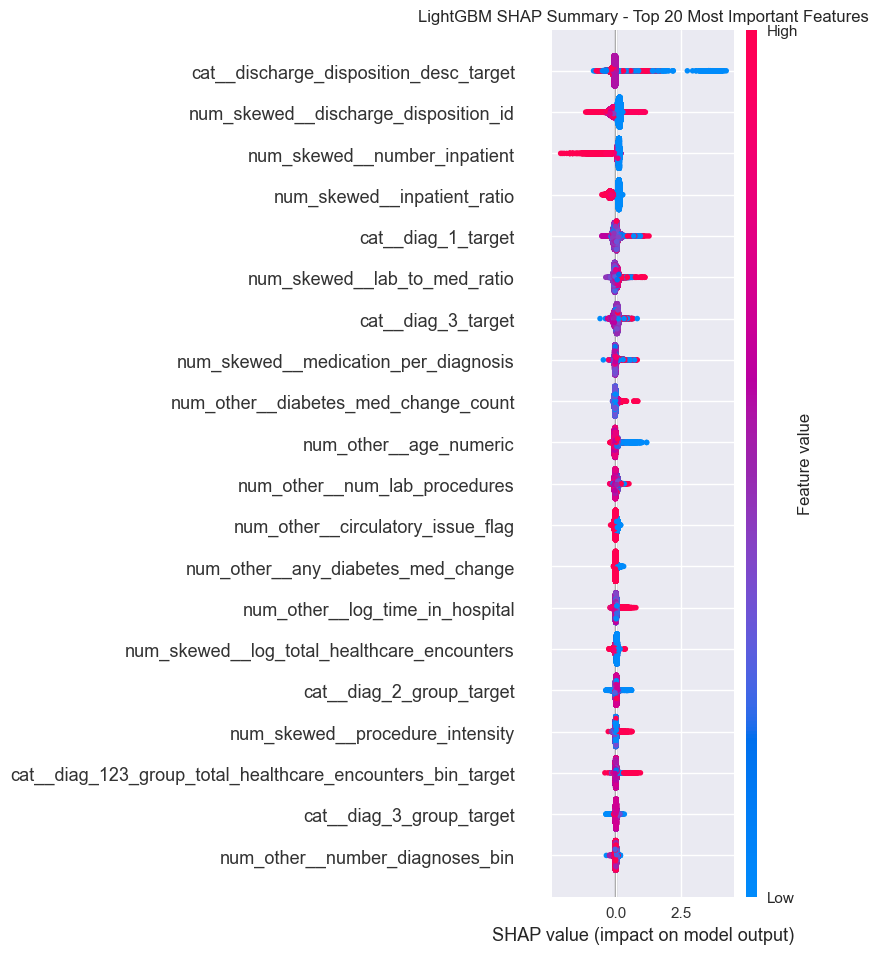

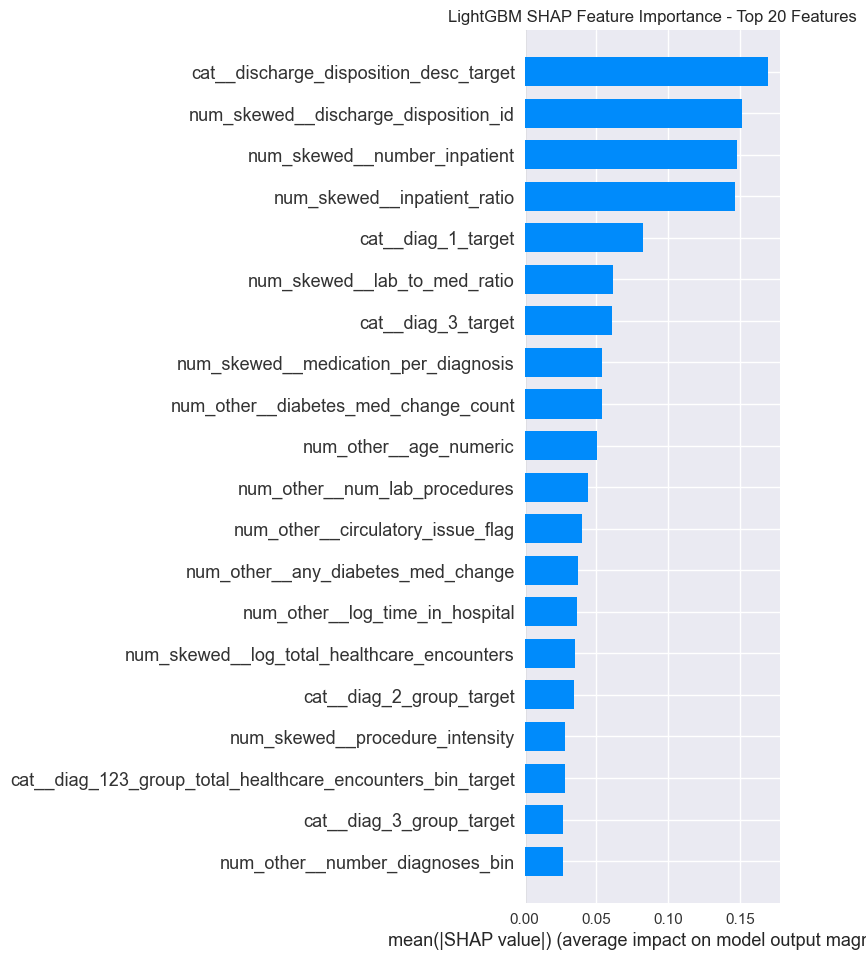

In [52]:
# SHAP analysis using the LightGBM estimator
lightgbm_estimator = baseline_results['LightGBM']['estimator']
lightgbm_estimator.booster_.predict(  # warm-up prediction to ensure the booster is initialised
    X_test_final,
    num_iteration=lightgbm_estimator.booster_.best_iteration or lightgbm_estimator.booster_.current_iteration()
)

explainer_lgbm = shap.TreeExplainer(lightgbm_estimator)
shap_values_lgbm = explainer_lgbm.shap_values(X_test_final)

if isinstance(shap_values_lgbm, list):
    shap_values_positive = shap_values_lgbm[1]
else:
    shap_values_positive = shap_values_lgbm

# Create SHAP summary for ALL features
shap_all_df = pd.DataFrame(
    shap_values_positive,
    columns=X_test_final.columns,
    index=X_test_final.index
)

shap_all_summary = pd.DataFrame({
    'mean_abs_shap': shap_all_df.abs().mean(),
    'mean_shap': shap_all_df.mean(),
    'feature_mean': X_test_final.mean()
}).sort_values('mean_abs_shap', ascending=False)

print("SHAP contribution summary for ALL features (LightGBM, test set):")
print("Top 20 most important features:")
display(shap_all_summary.head(20))

# SHAP summary plot for all features (top 20 most important)
top_20_features = shap_all_summary.head(20).index.tolist()
top_20_indices = [X_test_final.columns.get_loc(feature) for feature in top_20_features]

shap.summary_plot(
    shap_values_positive[:, top_20_indices],
    X_test_final[top_20_features],
    feature_names=top_20_features,
    show=False
)
plt.title('LightGBM SHAP Summary - Top 20 Most Important Features')
plt.show()

# Additional plot: SHAP bar plot for feature importance
shap.summary_plot(
    shap_values_positive[:, top_20_indices],
    X_test_final[top_20_features],
    feature_names=top_20_features,
    plot_type="bar",
    show=False
)
plt.title('LightGBM SHAP Feature Importance - Top 20 Features')
plt.show()

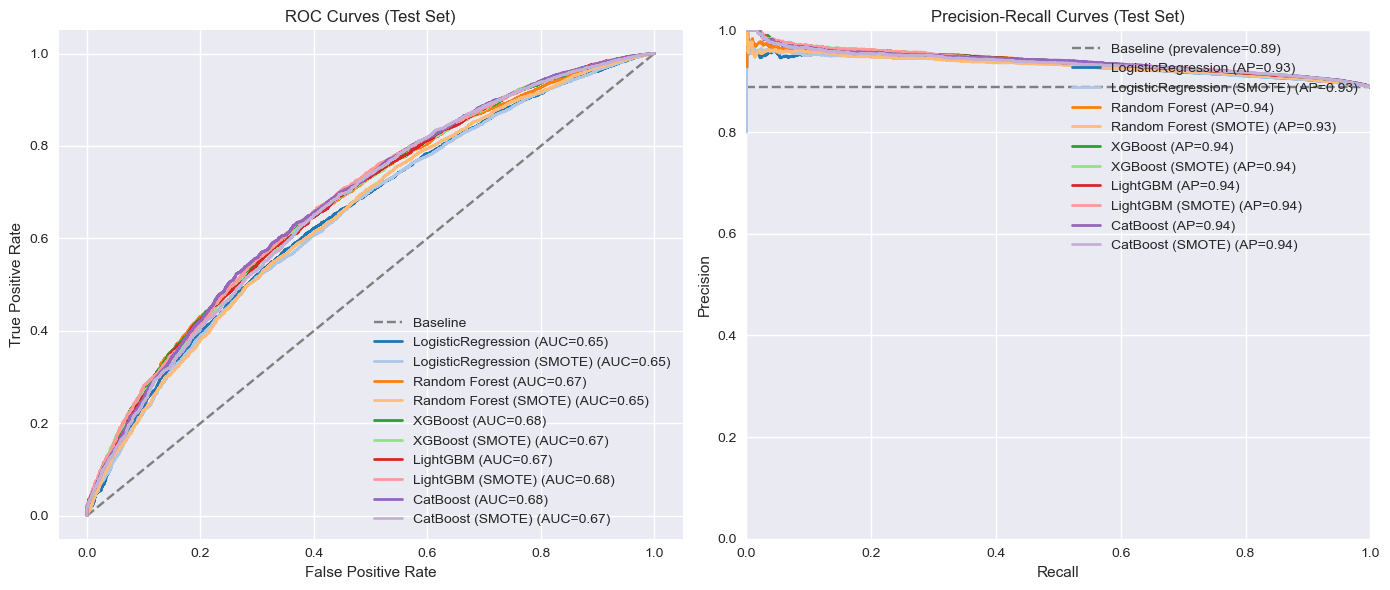

In [53]:
# ROC-AUC and Precision-Recall curves for all models on the same axes
plt.figure(figsize=(14, 6))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

# Baseline lines
ax1.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Baseline')
positive_rate = y_test.mean()
ax2.hlines(positive_rate, 0, 1, linestyles='--', colors='gray', label=f'Baseline (prevalence={positive_rate:.2f})')
palette = sns.color_palette('tab20', n_colors=len(baseline_results)) if len(baseline_results) > 0 else ['steelblue']

for (model_name, metrics), color in zip(baseline_results.items(), palette):
    probs = metrics['test']['probabilities']
    fpr, tpr, _ = roc_curve(y_test, probs)
    precision, recall, _ = precision_recall_curve(y_test, probs)
    auc_score = metrics['test']['roc_auc']
    ap_score = average_precision_score(y_test, probs)
    ax1.plot(fpr, tpr, label=f"{model_name} (AUC={auc_score:.2f})", color=color, linewidth=2)
    ax2.plot(recall, precision, label=f"{model_name} (AP={ap_score:.2f})", color=color, linewidth=2)

ax1.set_title('ROC Curves (Test Set)')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.legend(loc='lower right')

ax2.set_title('Precision-Recall Curves (Test Set)')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [54]:
# Threshold tuning to improve recall under class imbalance

def sweep_thresholds(y_true: pd.Series,
                     probs: np.ndarray,
                     model_name: str,
                     precision_floor: float = 0.20,
                     thresholds: np.ndarray | None = None) -> tuple[pd.DataFrame, dict]:
    if thresholds is None:
        thresholds = np.linspace(0.05, 0.95, 19)
    records = []
    for thr in thresholds:
        preds = (probs >= thr).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, preds).ravel()
        specificity = tn / (tn + fp) if (tn + fp) else 0.0
        records.append({
            'threshold': thr,
            'precision': precision_score(y_true, preds, zero_division=0),
            'recall': recall_score(y_true, preds, zero_division=0),
            'f1': f1_score(y_true, preds, zero_division=0),
            'accuracy': accuracy_score(y_true, preds),
            'balanced_accuracy': balanced_accuracy_score(y_true, preds),
            'specificity': specificity,
            'tp': tp,
            'fp': fp,
            'fn': fn,
            'tn': tn
        })
    sweep_df = pd.DataFrame(records)
    best_f1_row = sweep_df.loc[sweep_df['f1'].idxmax()].to_dict()
    feasible = sweep_df[sweep_df['precision'] >= precision_floor]
    best_recall_row = (
        feasible.loc[feasible['recall'].idxmax()].to_dict()
        if not feasible.empty else None
    )

    print(f"\nThreshold sweep for {model_name}")
    print("Best F1:")
    print(pd.Series(best_f1_row)[['threshold', 'precision', 'recall', 'f1', 'balanced_accuracy', 'specificity']])
    if best_recall_row is not None:
        print(f"Best recall with precision ≥ {precision_floor:.2f}:")
        print(pd.Series(best_recall_row)[['threshold', 'precision', 'recall', 'f1', 'balanced_accuracy', 'specificity']])
    else:
        print(f"No thresholds achieved precision ≥ {precision_floor:.2f}.")

    display(sweep_df[['threshold', 'precision', 'recall', 'f1', 'balanced_accuracy', 'specificity']])
    return sweep_df, {
        'best_f1': best_f1_row,
        'best_recall': best_recall_row
    }

threshold_analyses = {}
for model_name in ['LogisticRegression', 'LightGBM']:
    probs = baseline_results[model_name]['test']['probabilities']
    sweep_df, summary = sweep_thresholds(y_test, probs, model_name, precision_floor=0.25)
    threshold_analyses[model_name] = {
        'table': sweep_df,
        'summary': summary
    }



Threshold sweep for LogisticRegression
Best F1:
threshold            0.050000
precision            0.888425
recall               1.000000
f1                   0.940916
balanced_accuracy    0.500000
specificity          0.000000
dtype: float64
Best recall with precision ≥ 0.25:
threshold            0.050000
precision            0.888425
recall               1.000000
f1                   0.940916
balanced_accuracy    0.500000
specificity          0.000000
dtype: float64


,threshold,precision,recall,f1,balanced_accuracy,specificity
0,0.05,0.888425,1.000000,0.940916,0.500000,0.000000
1,0.10,0.888408,0.999834,0.940834,0.499917,0.000000
2,0.15,0.888927,0.999336,0.940904,0.502530,0.005724
3,0.20,0.889443,0.997014,0.940161,0.505112,0.013210
4,0.25,0.891266,0.988166,0.937218,0.514118,0.040070
5,0.30,0.895003,0.960681,0.926680,0.531640,0.102598
6,0.35,0.900637,0.915280,0.907899,0.555614,0.195949
7,0.40,0.907222,0.841951,0.873369,0.578175,0.314399
8,0.45,0.913402,0.759443,0.829338,0.593063,0.426684
9,0.50,0.922652,0.646464,0.760251,0.607468,0.568472



Threshold sweep for LightGBM
Best F1:
threshold            0.100000
precision            0.888507
recall               0.999945
f1                   0.940938
balanced_accuracy    0.500413
specificity          0.000881
dtype: float64
Best recall with precision ≥ 0.25:
threshold            0.050000
precision            0.888425
recall               1.000000
f1                   0.940916
balanced_accuracy    0.500000
specificity          0.000000
dtype: float64


,threshold,precision,recall,f1,balanced_accuracy,specificity
0,0.05,0.888425,1.000000,0.940916,0.500000,0.000000
1,0.10,0.888507,0.999945,0.940938,0.500413,0.000881
2,0.15,0.889255,0.998673,0.940793,0.504180,0.009687
3,0.20,0.891649,0.994359,0.940208,0.516114,0.037869
4,0.25,0.895396,0.984129,0.937668,0.534336,0.084544
5,0.30,0.898221,0.968755,0.932156,0.547345,0.125936
6,0.35,0.903581,0.934911,0.918979,0.570274,0.205636
7,0.40,0.909315,0.878892,0.893844,0.590481,0.302070
8,0.45,0.915417,0.806780,0.857672,0.606604,0.406429
9,0.50,0.923331,0.711276,0.803549,0.620499,0.529723


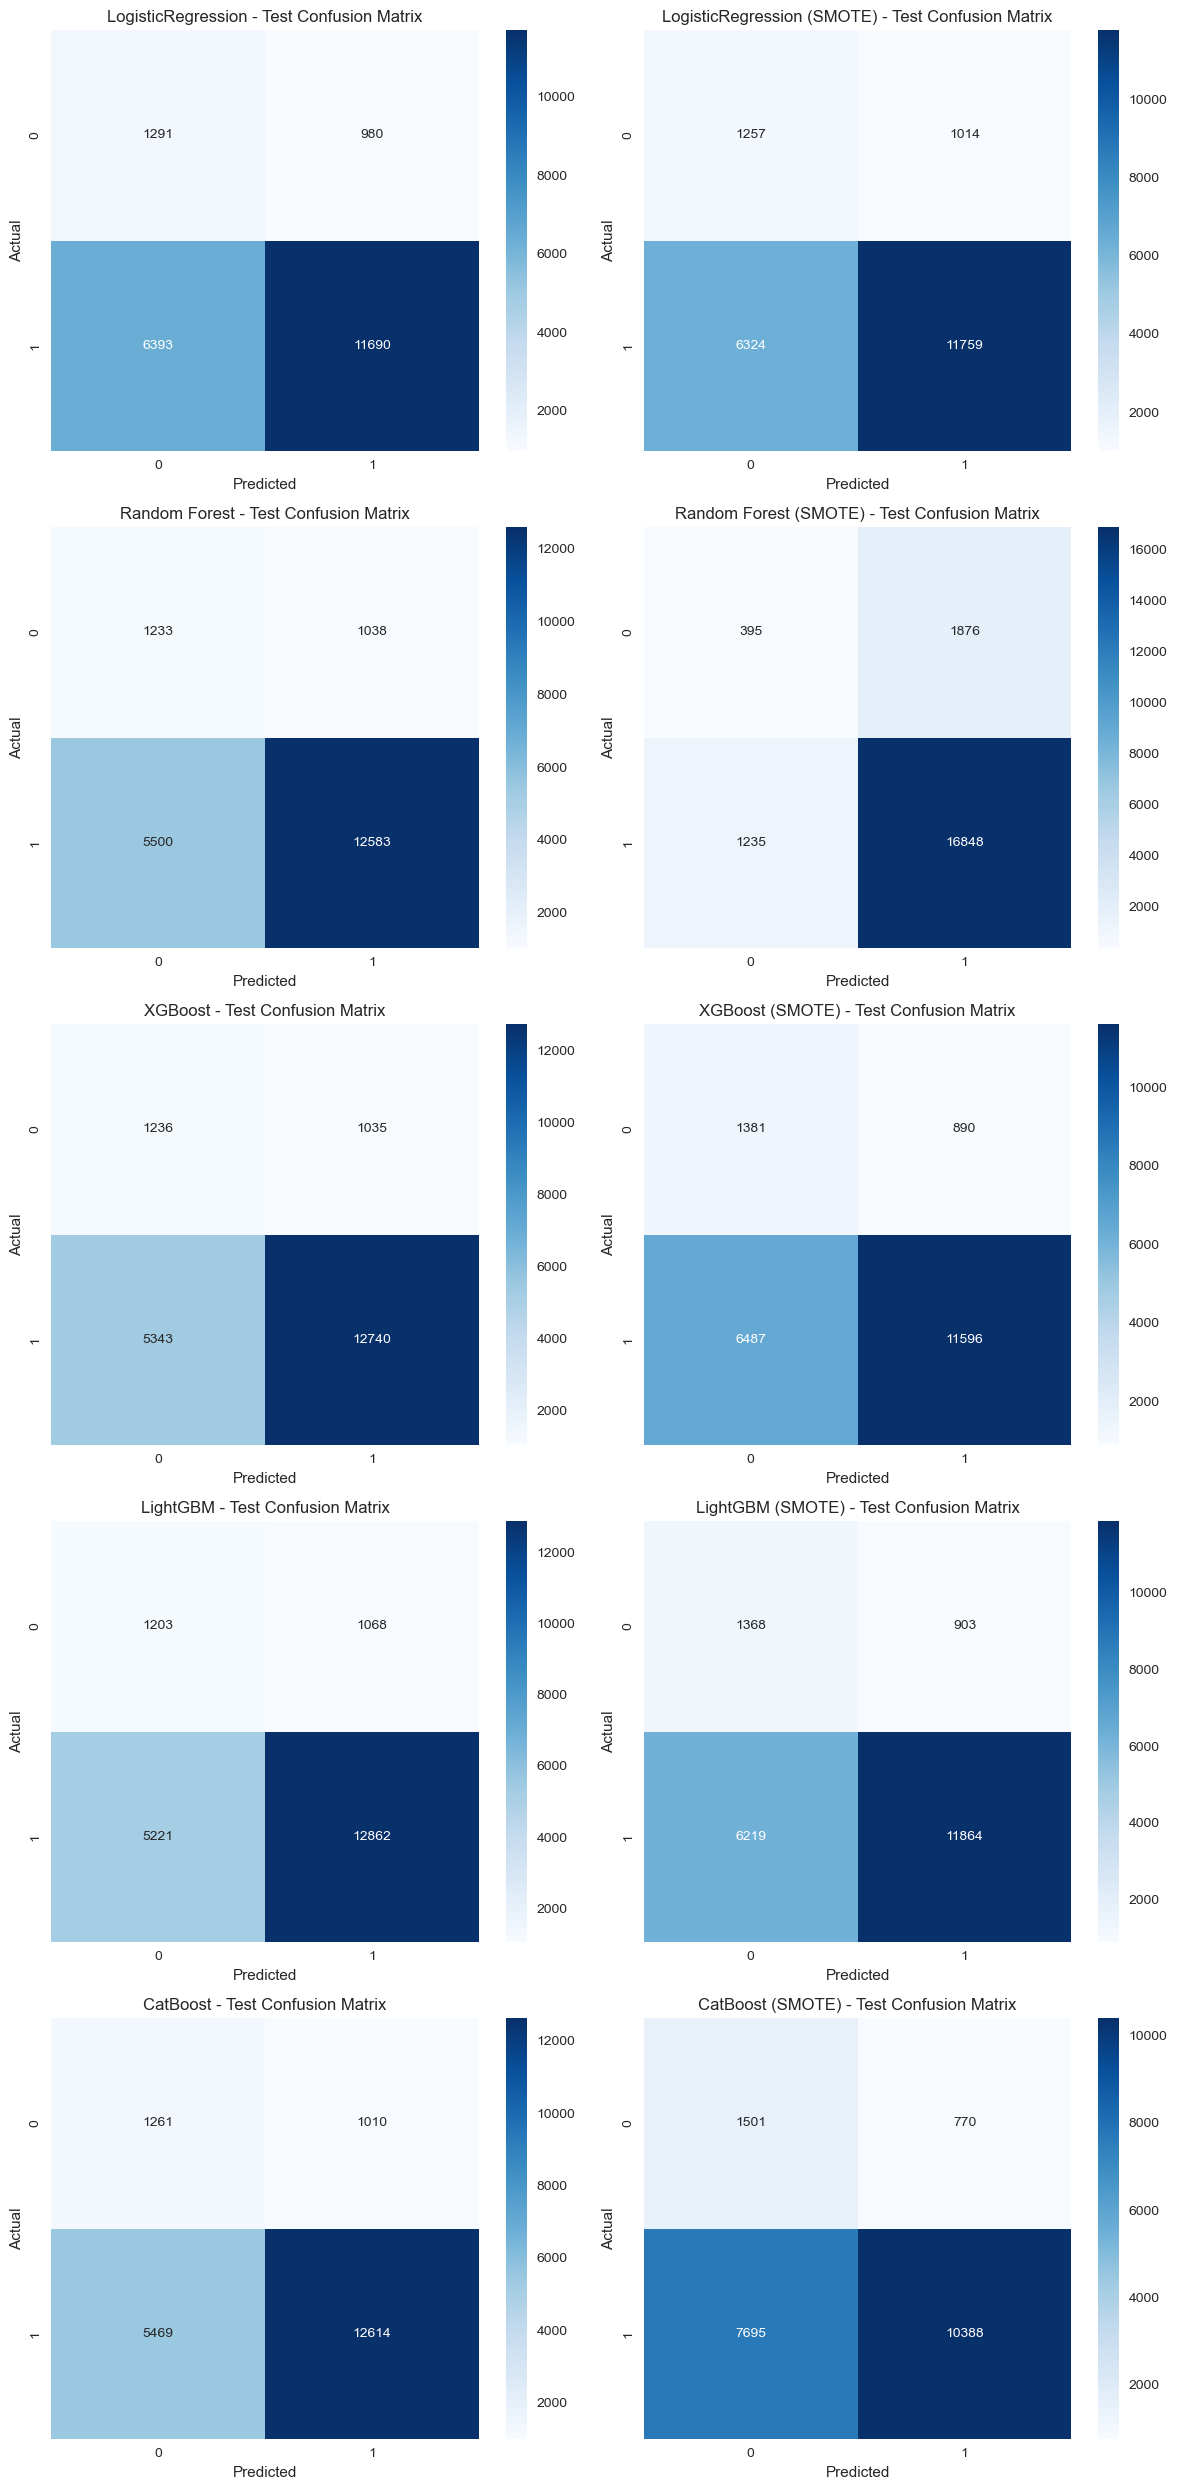

In [55]:
# Confusion matrices for each model on the test set
n_models = len(baseline_results)
rows = int(np.ceil(n_models / 2))
fig, axes = plt.subplots(rows, 2, figsize=(12, 5 * rows))
axes = axes.flatten()

for idx, (model_name, metrics) in enumerate(baseline_results.items()):
    cm = metrics['test']['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx])
    axes[idx].set_title(f'{model_name} - Test Confusion Matrix')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')

for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

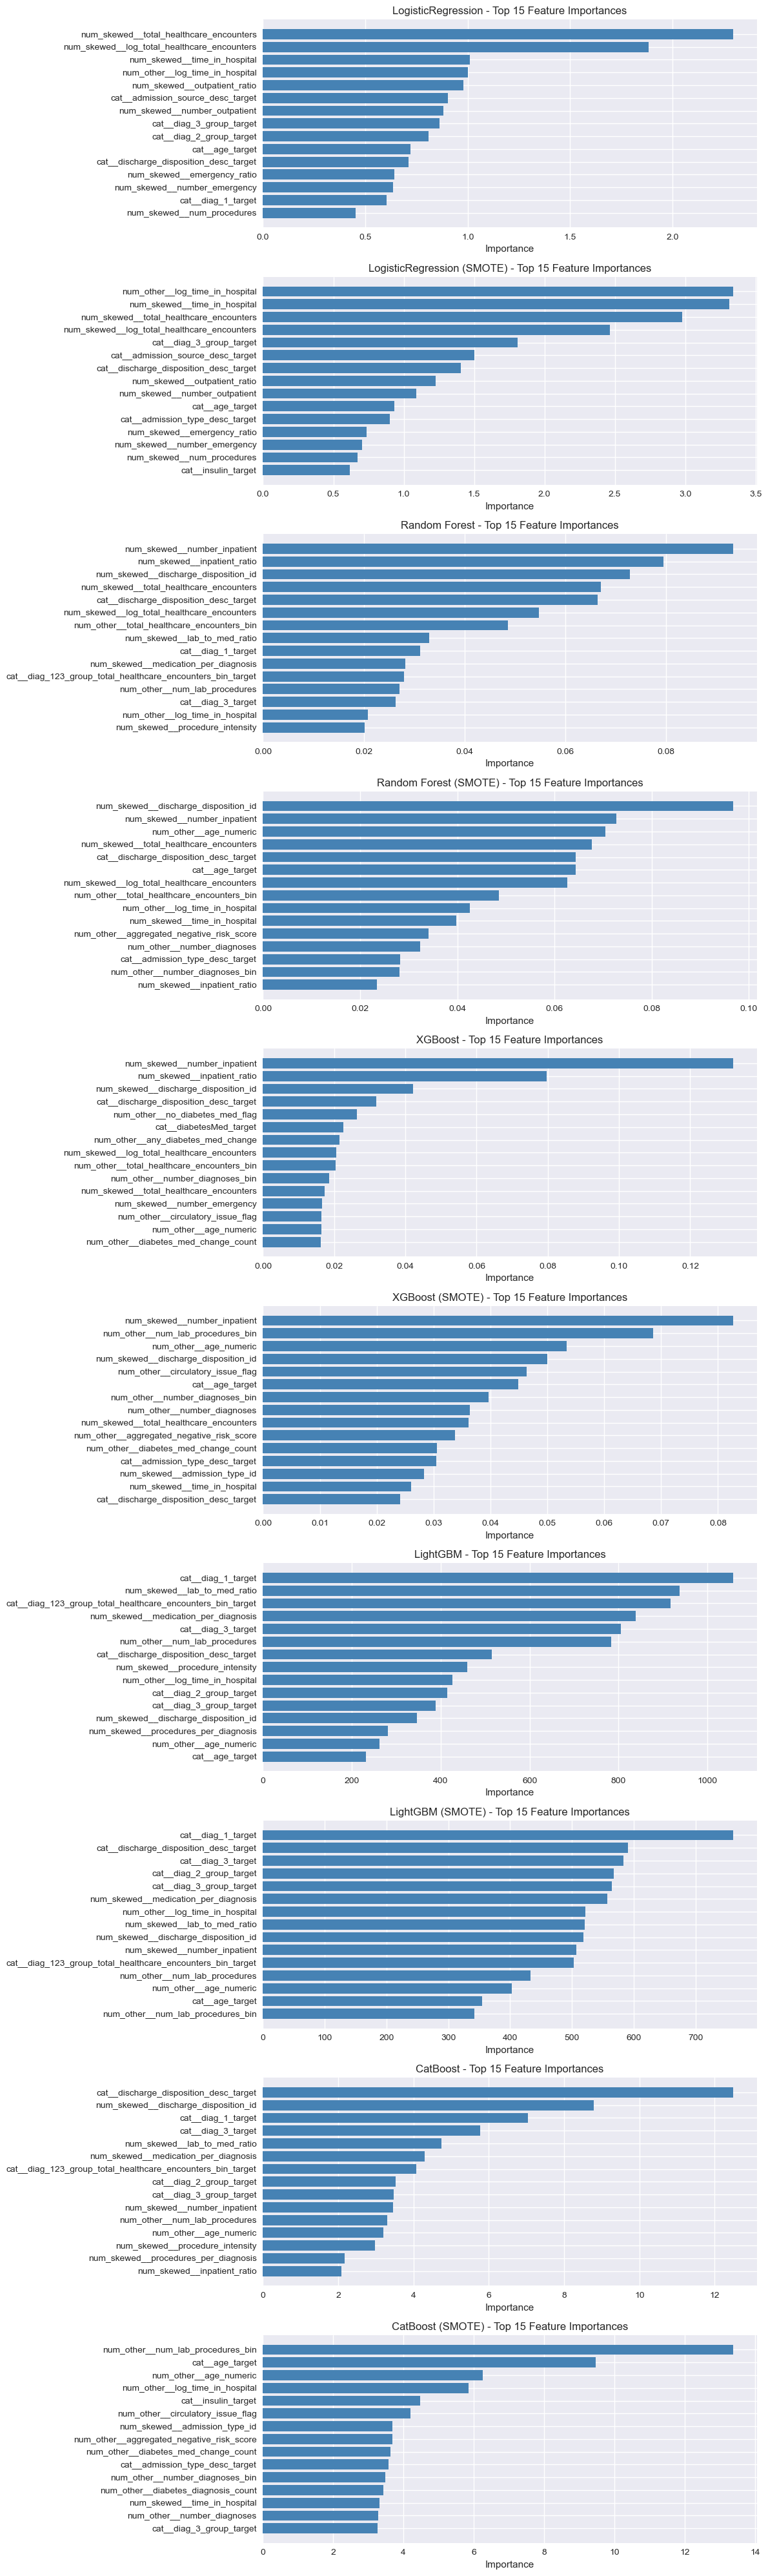

In [56]:
# Feature importance analysis per model
def plot_feature_importances(results: dict, feature_names: list[str], top_n: int = 15):
    n_models = len(results)
    fig, axes = plt.subplots(n_models, 1, figsize=(12, 4 * n_models))
    if n_models == 1:
        axes = [axes]
    for ax, (model_name, metrics) in zip(axes, results.items()):
        estimator = metrics['estimator']
        if hasattr(estimator, 'feature_importances_'):
            importances = estimator.feature_importances_
        elif hasattr(estimator, 'coef_'):
            importances = np.abs(estimator.coef_.ravel())
        else:
            ax.set_visible(False)
            continue
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        })
        top_features = (
            importance_df.sort_values('importance', ascending=False).head(top_n).iloc[::-1]
        )
        ax.barh(top_features['feature'], top_features['importance'], color='steelblue')
        ax.set_title(f'{model_name} - Top {top_n} Feature Importances')
        ax.set_xlabel('Importance')
    plt.tight_layout()
    plt.show()

plot_feature_importances(baseline_results, X_train_final.columns.tolist(), top_n=15)

In [57]:
# Permutation importance to validate feature contributions
def permutation_report(results_dict: dict,
                        model_key: str,
                        X: pd.DataFrame,
                        y: pd.Series,
                        scoring: str = 'f1',
                        top_n: int = 20,
                        return_full: bool = False,
                        n_jobs: int = 1,
                        random_state: int = 42) -> pd.DataFrame:
    estimator = results_dict[model_key]['estimator']
    result = permutation_importance(
        estimator,
        X,
        y,
        n_repeats=10,
        random_state=random_state,
        scoring=scoring,
        n_jobs=n_jobs
    )
    full_importances_df = pd.DataFrame({
        'feature': X.columns,
        'importance_mean': result.importances_mean,
        'importance_std': result.importances_std
    }).sort_values(by='importance_mean', ascending=False)
    print(f"Top {top_n} permutation importances for {model_key} (scoring={scoring}):")
    display(full_importances_df.head(top_n))
    return full_importances_df if return_full else full_importances_df.head(top_n)

# Run sequentially (n_jobs=1) to avoid binary incompatibilities when spawning worker processes
perm_importance_logreg_full = permutation_report(
    baseline_results,
    'LogisticRegression',
    X_test_final,
    y_test,
    return_full=True,
    n_jobs=1
)
perm_importance_lgbm_full = permutation_report(
    baseline_results,
    'LightGBM',
    X_test_final,
    y_test,
    return_full=True,
    n_jobs=1
)

Top 20 permutation importances for LogisticRegression (scoring=f1):


,feature,importance_mean,importance_std
38,num_skewed__time_in_hospital,0.098899,0.001769
28,num_other__log_time_in_hospital,0.089149,0.002180
23,num_skewed__num_procedures,0.063726,0.001640
32,num_skewed__total_healthcare_encounters,0.044759,0.001997
14,num_other__number_diagnoses_bin,0.034008,0.001215
34,num_other__log_num_procedures,0.028329,0.001852
36,num_other__number_diagnoses,0.024685,0.001373
7,num_skewed__number_outpatient,0.019799,0.001115
18,num_skewed__log_total_healthcare_encounters,0.016953,0.001548
39,num_skewed__outpatient_ratio,0.014624,0.000981


Top 20 permutation importances for LightGBM (scoring=f1):


,feature,importance_mean,importance_std
47,num_skewed__number_inpatient,0.008741,0.000516
50,num_other__age_numeric,0.003530,0.000474
44,cat__admission_source_desc_target,0.003487,0.000272
27,cat__discharge_disposition_desc_target,0.003052,0.000701
8,cat__admission_type_desc_target,0.001288,0.000357
46,num_skewed__admission_type_id,0.000896,0.000361
4,num_other__diabetes_diagnosis_count,0.000888,0.000570
15,num_other__diabetes_med_change_count,0.000311,0.000596
7,num_skewed__number_outpatient,0.000189,0.000237
31,num_other__aggregated_negative_risk_score,0.000188,0.000345


In [58]:
# Focus on negative-risk feature importances from permutation tests
negative_perm_summary = []
for model_name, importances_df in [
    ('LogisticRegression', perm_importance_logreg_full),
    ('LightGBM', perm_importance_lgbm_full)
]:
    subset = importances_df[importances_df['feature'].isin(negative_risk_num_features)].copy()
    subset['model'] = model_name
    negative_perm_summary.append(subset)

negative_perm_summary_df = (
    pd.concat(negative_perm_summary)
    .sort_values(by=['model', 'importance_mean'], ascending=[True, False])
)

print("Permutation importance (F1) restricted to negative-risk engineered signals:")
display(negative_perm_summary_df[['model', 'feature', 'importance_mean', 'importance_std']])

Permutation importance (F1) restricted to negative-risk engineered signals:


,model,feature,importance_mean,importance_std
31,LightGBM,num_other__aggregated_negative_risk_score,0.000188,0.000345
24,LightGBM,num_other__strong_negative_signature,0.000142,0.000187
22,LightGBM,num_other__no_diabetes_med_flag,0.000092,0.000049
9,LightGBM,num_other__diag_3_group_low_risk_flag,0.000068,0.000278
43,LightGBM,num_other__stable_medication_flag,-0.000096,0.000090
1,LightGBM,num_other__diag_2_group_low_risk_flag,-0.000154,0.000195
19,LightGBM,num_other__diag_1_group_low_risk_flag,-0.000954,0.000344
22,LogisticRegression,num_other__no_diabetes_med_flag,0.011212,0.000822
24,LogisticRegression,num_other__strong_negative_signature,0.002393,0.000420
43,LogisticRegression,num_other__stable_medication_flag,0.002163,0.000743


In [59]:
# Confusion matrix breakdown by key demographic/clinical groups (using Logistic Regression)
def confusion_breakdown(estimator, X, y_true, metadata: pd.DataFrame, feature: str) -> pd.DataFrame:
    y_pred = estimator.predict(X)
    rows = []
    for level, idx in metadata.groupby(feature).groups.items():
        true_subset = y_true.loc[idx]
        pred_subset = pd.Series(y_pred, index=X.index).loc[idx]
        cm = confusion_matrix(true_subset, pred_subset, labels=[0, 1])
        tn, fp, fn, tp = cm.ravel()
        rows.append({
            feature: level,
            'support': len(true_subset),
            'TN': tn,
            'FP': fp,
            'FN': fn,
            'TP': tp,
            'specificity': tn / (tn + fp) if (tn + fp) > 0 else np.nan,
            'recall': tp / (tp + fn) if (tp + fn) > 0 else np.nan
        })
    return pd.DataFrame(rows).sort_values('support', ascending=False)

log_reg_estimator = baseline_results['LightGBM']['estimator']
test_metadata = baseline_df.loc[X_test_final.index, ['race', 'age', 'diag_1_group', 'diag_2_group', 'diag_3_group']]

for feature in test_metadata.columns:
    print(f"\nConfusion breakdown by {feature}:")
    display(confusion_breakdown(log_reg_estimator, X_test_final, y_test, test_metadata, feature))


Confusion breakdown by race:


,race,support,TN,FP,FN,TP,specificity,recall
3,Caucasian,15314,910,812,3973,9619,0.528455,0.707696
1,AfricanAmerican,3775,217,204,971,2383,0.515439,0.710495
0,?,465,19,24,106,316,0.441860,0.748815
4,Hispanic,405,34,9,97,265,0.790698,0.732044
5,Other,286,16,14,53,203,0.533333,0.792969
2,Asian,109,7,5,21,76,0.583333,0.783505



Confusion breakdown by age:


,age,support,TN,FP,FN,TP,specificity,recall
7,[70-80),5270,345,299,1552,3074,0.535714,0.664505
6,[60-70),4400,244,234,1062,2860,0.510460,0.729220
5,[50-60),3516,146,155,704,2511,0.485050,0.781026
8,[80-90),3472,258,203,1133,1878,0.559653,0.623713
4,[40-50),1887,107,94,380,1306,0.532338,0.774614
3,[30-40),742,51,28,140,523,0.645570,0.788839
9,[90-100),545,25,32,160,328,0.438596,0.672131
2,[20-30),343,27,12,83,221,0.692308,0.726974
1,[10-20),151,0,10,7,134,0.000000,0.950355
0,[0-10),28,0,1,0,27,0.000000,1.000000



Confusion breakdown by diag_1_group:


,diag_1_group,support,TN,FP,FN,TP,specificity,recall
0,Circulatory,6081,359,344,1573,3805,0.510669,0.707512
10,Respiratory,2898,154,149,633,1962,0.508251,0.756069
2,Digestive,1881,108,97,425,1251,0.526829,0.746420
1,Diabetes,1722,139,91,532,960,0.604348,0.643432
6,Injury,1409,107,59,501,742,0.644578,0.596943
4,Genitourinary,982,43,63,285,591,0.405660,0.674658
7,Musculoskeletal,981,50,41,224,666,0.549451,0.748315
8,Neoplasms,664,18,37,93,516,0.327273,0.847291
17,"symptoms, signs, and ill-defined conditions",646,39,26,181,400,0.600000,0.688468
3,"Endocrine, nutritional and metabolic diseases,...",566,31,36,159,340,0.462687,0.681363



Confusion breakdown by diag_2_group:


,diag_2_group,support,TN,FP,FN,TP,specificity,recall
0,Circulatory,6391,384,355,1661,3991,0.519621,0.706122
1,Diabetes,2540,138,139,494,1769,0.498195,0.781706
10,Respiratory,2174,122,112,602,1338,0.521368,0.689691
4,Genitourinary,1663,105,96,505,957,0.522388,0.654583
3,"Endocrine, nutritional and metabolic diseases,...",1653,107,73,431,1042,0.594444,0.707400
2,Digestive,825,49,43,198,535,0.532609,0.729877
15,diseases of the skin and subcutaneous tissue,723,58,43,259,363,0.574257,0.583601
9,Other,615,29,29,129,428,0.500000,0.768402
13,diseases of the blood and blood-forming organs,589,26,20,158,385,0.565217,0.709024
17,"symptoms, signs, and ill-defined conditions",572,35,20,124,393,0.636364,0.760155



Confusion breakdown by diag_3_group:


,diag_3_group,support,TN,FP,FN,TP,specificity,recall
0,Circulatory,6059,381,325,1542,3811,0.539660,0.711937
1,Diabetes,3385,175,169,732,2309,0.508721,0.759290
3,"Endocrine, nutritional and metabolic diseases,...",1879,105,114,396,1264,0.479452,0.761446
10,Respiratory,1477,85,71,453,868,0.544872,0.657078
4,Genitourinary,1326,118,57,477,674,0.674286,0.585578
9,Other,1301,49,66,263,923,0.426087,0.778246
2,Digestive,773,41,45,180,507,0.476744,0.737991
17,"symptoms, signs, and ill-defined conditions",634,38,37,168,391,0.506667,0.699463
16,mental disorders,619,39,32,154,394,0.549296,0.718978
15,diseases of the skin and subcutaneous tissue,505,39,23,238,205,0.629032,0.462754
